# Using Machine Learning to Estimate Ratings of Bangladeshi Restaurants from Reviews

## Data Exploration and Visualization

### Data and package importation

The dataset I will be working with is sourced from [Mendeley Data](https://data.mendeley.com/datasets/wc87kpk6ks/1), a reputable open-source data repository. 
This particular dataset consists of user reviews extracted from restaurants located in various places in the city of Dhaka

Key information such as the review text, user ratings, and the date of the review post were compiled.

In [5]:
# Import the packages that we will be using
import pandas as pd
import scipy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import emoji
import nltk
import timeit
import pydot
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, LSTM 
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet

# Ensure that NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoinem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
# Load the data from a CSV file
rws = pd.read_csv('data.csv')

### Data Vizualization

In the following step, I'm going to change the dataset to better suit my needs by removing columns that are not pertinent to our analysis. Additionally, I will assign more descriptive names to certain columns to enhance clarity and facilitate easier data handling.

In [7]:
# Drop the 'Unnamed: 0' and 'createdAt' columns from the dataframe 
rws = rws.drop(columns=['Unnamed: 0', 'createdAt', 'reviewerName',])

# Rename specific columns to more descriptive names:
rws.rename(columns={'text': 'review', 'ratingvalue': 'rating'}, inplace=True)

# Convert the 'rating' column to numeric
rws['rating'] = pd.to_numeric(rws['rating'], errors='coerce')

# Display the first 5 rows
print(rws.head())

                                              review  rating
0  To tell you the truth, they sell fried chicken...       1
1                                  Crispy was so bad       3
2  The restaurant provided leas items which I ord...       1
3  already send you a picture about my meal. tota...       1
4                                Excellent as before       5


In the following sections, we will explore the dataset in more detail. We'll begin by presenting a series of visualizations that will give us insights into the distribution, trends, and relationships within the data.

Let's dive into the visuals to better understand our dataset.

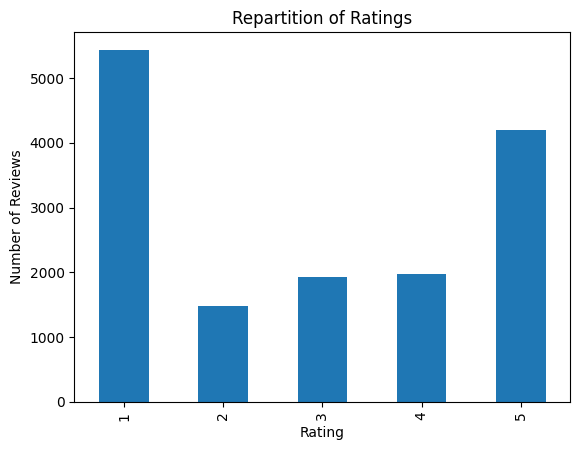

In [8]:
# Define the desired order of ratings
desired_order = [1, 2, 3, 4, 5]

# Calculate the counts of each rating
rating_counts = rws['rating'].value_counts()

# Reindex the rating_counts Series with the desired order
rating_counts = rating_counts.reindex(desired_order)

# Plot the repartition of ratings with the updated x-axis order
rating_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Repartition of Ratings')

# Show the plot
plt.show()


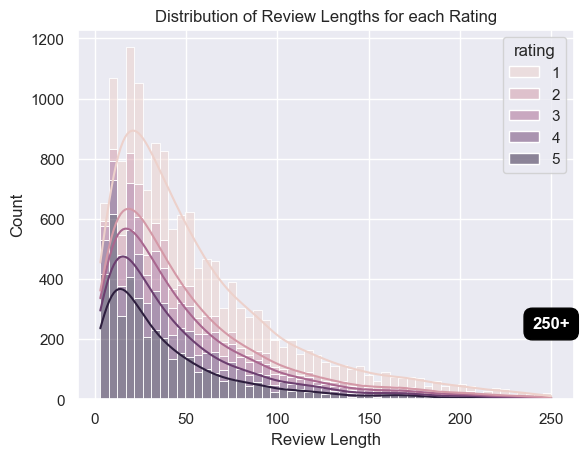

In [9]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the plot
sns.set(style="darkgrid")

# Calculate the length of reviews
rws['review_length'] = rws['review'].apply(len)

# Filter the review lengths greater than 250
filtered_rws = rws[rws['review_length'] <= 250]

# Plot the distribution of review lengths for each rating
sns.histplot(data=filtered_rws, x="review_length", hue="rating", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Review Lengths for each Rating")
plt.xlabel("Review Length")
plt.ylabel("Count")

# Add a label for review lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

In [10]:
# Define a function to preprocess the reviews
longest_review = rws.loc[rws['review_length'].idxmax(), 'review']

print(longest_review)

When the delivery man arrived at my house, he called me to let me know that he had sent the food upstairs with my guard. I asked him to kindly wait downstairs so that I can send him the money to which he replied said the food has been paid for. I was quite taken aback and said that's not possible because I had opted for COD payment, and he just said "achcha ami dekhtesi" and then he just hung up on my face " I mean? Excuse me? I obviously lost my temper, called him back and asked him what sort of nonsense is this and why he kept the phone on my face. He was dumbfounded and did not say a word. I asked him to wait downstairs while I send the guard with the payment. Once your delivery-man had received the payment, he had the audacity to call me back and ask why I said what I said. To recall the conversation, when he hung up on my face my exact words when I called him back were "apni amar mukher upor keno phone rakhlen? Faizlami peyechen apni? Ami toh bolchi cash eh payment hobe, apni nich

In [11]:
rws.drop('review_length', axis=1, inplace=True)

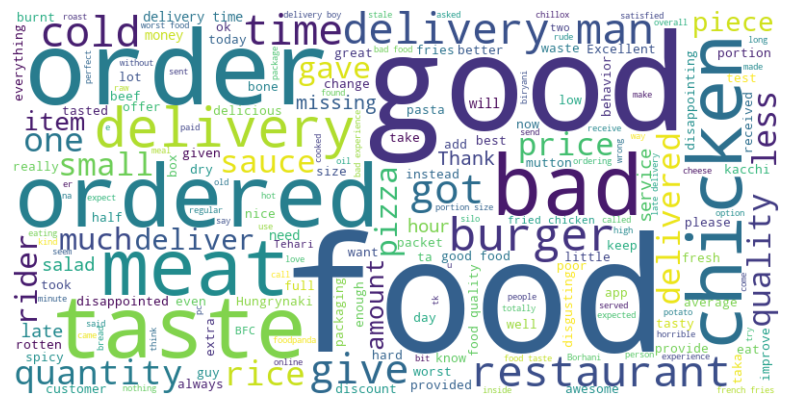

In [12]:
# Concatenate all the reviews into a single string
all_reviews = ' '.join(rws['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Data Categorization

### Data Categorization

I will create two categories for my reviews: Positive reviews, which are those with a rating strictly greater than 3, and Negative reviews, which include reviews with a rating strictly less than 3.

In [13]:
# Define a function that categorizes the rating
def categorize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 'Neutral'  # This handles ratings exactly equal to 3

# Apply the function to the 'rating' column
rws['rating'] = rws['rating'].apply(categorize_rating)

# Remove rows where the review_category is 'Neutral'
rws = rws[rws['rating'] != 'Neutral']

# Display the DataFrame to verify that 'Neutral' reviews have been removed
print(rws.head())

                                              review rating
0  To tell you the truth, they sell fried chicken...      0
2  The restaurant provided leas items which I ord...      0
3  already send you a picture about my meal. tota...      0
4                                Excellent as before      1
5  They forgot to include the beverages that were...      0


### Vizualization of the Categorization

Let's take a look at our newly categorized data to gain a clearer insight into how our future models will perform.

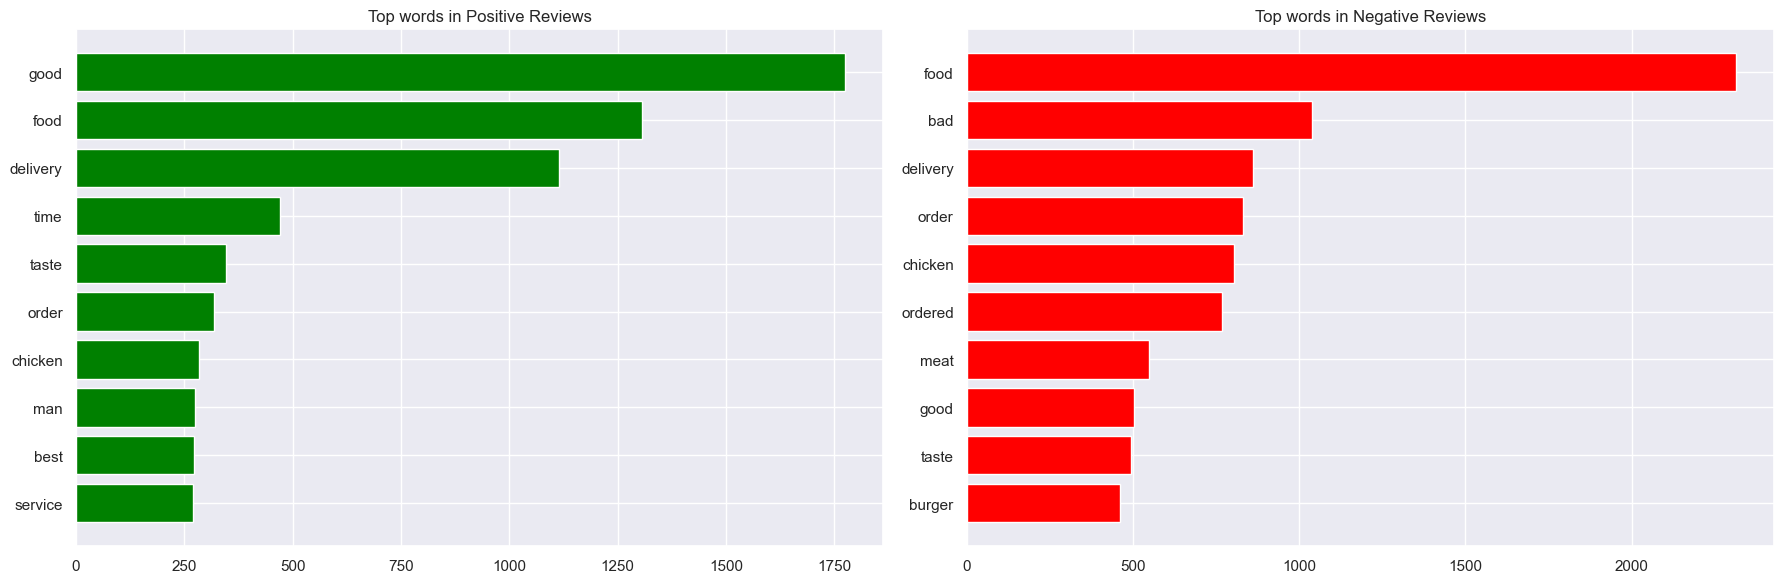

In [14]:
# Tokenize the reviews, remove stopwords, and count the word frequencies for positive and negative reviews separately.

# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Separate positive and negative reviews
positive_reviews = rws[rws['rating'] == 1]['review']
negative_reviews = rws[rws['rating'] == 0]['review']

# Apply the cleaning and tokenization function
positive_tokens = positive_reviews.apply(clean_tokenize).sum()
negative_tokens = negative_reviews.apply(clean_tokenize).sum()

# Count the frequencies of words
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

# Get the 10 most common words in positive and negative reviews
most_common_positive = positive_freq.most_common(10)
most_common_negative = negative_freq.most_common(10)

# Separate the words and their counts for the plot
positive_words, positive_counts = zip(*most_common_positive)
negative_words, negative_counts = zip(*most_common_negative)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot for positive reviews
ax[0].barh(positive_words, positive_counts, color='green')
ax[0].set_title('Top words in Positive Reviews')
ax[0].invert_yaxis()  # Labels read top-to-bottom

# Plot for negative reviews
ax[1].barh(negative_words, negative_counts, color='red')
ax[1].set_title('Top words in Negative Reviews')
ax[1].invert_yaxis()  # Labels read top-to-bottom

# Display the plot
plt.tight_layout()
plt.show()


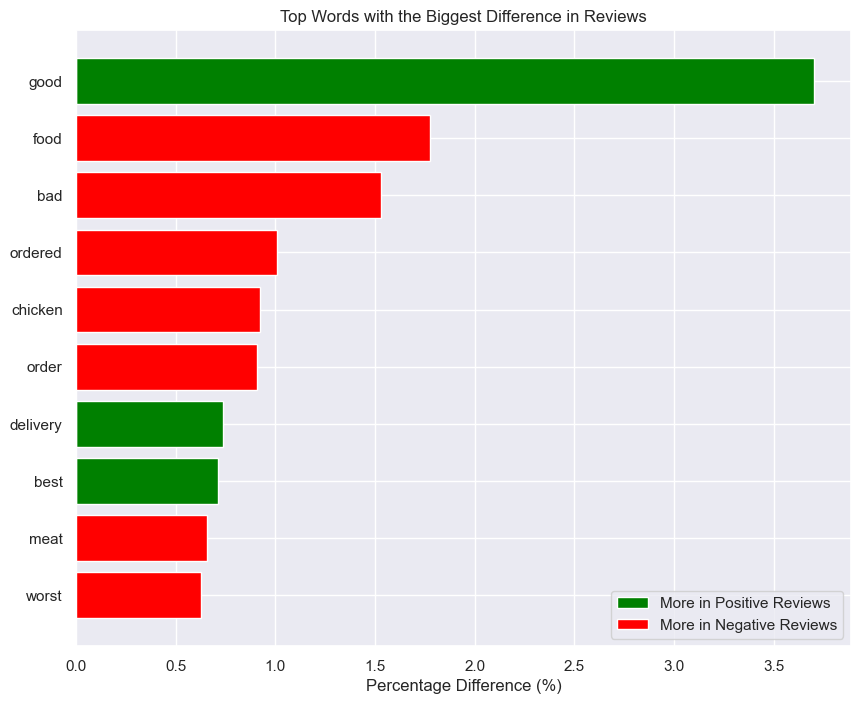

In [15]:
# Calculate the frequency difference for each word
frequency_diff = {word: positive_freq[word] - negative_freq[word] for word in set(positive_freq) | set(negative_freq)}

# Calculate the percentage difference for each word
total_pos_reviews = sum(positive_freq.values())
total_neg_reviews = sum(negative_freq.values())
percentage_diff = {word: (count / total_pos_reviews * 100 if count > 0 else count / total_neg_reviews * 100)
                   for word, count in frequency_diff.items()}

# Sort the words by the biggest absolute percentage difference
sorted_words = sorted(percentage_diff.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top words with the biggest difference
top_words = sorted_words[:10]  # Adjust the number as needed

# Split words and their percentage difference
words, differences = zip(*top_words)

# Split into positive and negative differences
pos_diffs = [percentage_diff[word] if percentage_diff[word] > 0 else 0 for word in words]
neg_diffs = [-percentage_diff[word] if percentage_diff[word] < 0 else 0 for word in words]

# Plotting
plt.figure(figsize=(10, 8))
y_pos = range(len(words))
plt.barh(y_pos, pos_diffs, color='green', label='More in Positive Reviews')
plt.barh(y_pos, neg_diffs, color='red', label='More in Negative Reviews')
plt.yticks(y_pos, words)
plt.xlabel('Percentage Difference (%)')
plt.title('Top Words with the Biggest Difference in Reviews')
plt.legend()
plt.gca().invert_yaxis()  # Highest percentages on top
plt.show()


### Text Preprocessing and Spliting

I will do text preprocessing in two distinct ways: 

**Large Cleaning Process :** This includes negation handling, emoji removal, lemmatization etc...

**Small Cleaning Process :** This maintaining more of the text's raw form.

*It will be beneficial to evaluate both versions with various models later on.*

Then I will also split the data into training and testing sets.

In [16]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def handle_negation(text):
    if text is None:
        return text
    # Pattern to detect negations followed by an alphanumeric word
    negation_pattern = re.compile(r'\b(not|no|never|none|nothing|nowhere|neither|nobody|cannot)\b[\s]*(\w+)')
    text = negation_pattern.sub(lambda x: f'{x.group(1)}_{x.group(2)}', text)
    return text

def full_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Handle negation
    text = handle_negation(text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # POS tagging
    nltk_pos_tagged = nltk.pos_tag(words)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_pos_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return ' '.join(lemmatized_words)

def raw_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

In [17]:
# Balance the dataset
# Separate the dataset into positives and negatives
positive_rws = rws[rws['rating'] == 1]
negative_rws = rws[rws['rating'] == 0]

# Downsample the majority class (positive reviews) to match the minority class (negative reviews)
min_count = min(len(positive_rws), len(negative_rws))
balanced_positive = positive_rws.sample(n=min_count, random_state=42)
balanced_negative = negative_rws.sample(n=min_count, random_state=42)

# Combine back to a single balanced dataframe
balanced_rws = pd.concat([balanced_positive, balanced_negative])

# Now perform a stratified split on the balanced dataset
train_rws, test_rws = train_test_split(balanced_rws, test_size=0.2, stratify=balanced_rws['rating'], random_state=42)

# Apply the thorough cleaning to the training and test sets
# Create new DataFrame for cleaned versions including ratings
cleaned_train = pd.DataFrame({
    'review': train_rws['review'].apply(full_clean_text),
    'rating': train_rws['rating']
})
cleaned_test = pd.DataFrame({
    'review': test_rws['review'].apply(full_clean_text),
    'rating': test_rws['rating']
})

# Apply the minimal cleaning to the training and test sets
# Create new DataFrame for raw versions including ratings
raw_train = pd.DataFrame({
    'review': train_rws['review'].apply(raw_clean_text),
    'rating': train_rws['rating']
})
raw_test = pd.DataFrame({
    'review': test_rws['review'].apply(raw_clean_text),
    'rating': test_rws['rating']
})

In [18]:
# Print the first two reviews from the cleaned training set
print("First two reviews from the Cleaned Training Set:")
print(cleaned_train['review'].iloc[0])
print(cleaned_train['review'].iloc[1])
print("\n")

# Print the first two reviews from the cleaned test set
print("First two reviews from the Cleaned Test Set:")
print(cleaned_test['review'].iloc[0])
print(cleaned_test['review'].iloc[1])
print("\n")

# Assuming the same indices can be used for the raw sets, since the split was stratified based on the rating
print("First two reviews from the Raw Training Set:")
print(raw_train['review'].iloc[0])
print(raw_train['review'].iloc[1])
print("\n")

print("First two reviews from the Raw Test Set:")
print(raw_test['review'].iloc[0])
print(raw_test['review'].iloc[1])

First two reviews from the Cleaned Training Set:
bhuna khichuri plenty meatbeef ittaste also good
delivery time


First two reviews from the Cleaned Test Set:
bad food cold soggy bag rip entire soda go waste no_cheese cheeseburger
please continue consistency pizza excellent taste really fresh also whole family could enjoy definitely order


First two reviews from the Raw Training Set:
Bhuna khichuri had plenty of meat ( Beef ) in it.Taste was also good .
delivery time


First two reviews from the Raw Test Set:
It was very bad . The food was cold and soggy . The bag ripped and my entire soda went to waste . And there was no cheese in my cheeseburger
Please continue this consistency ! The pizza is excellent ! It tasted really fresh ! Also my whole family could enjoy it . Definitely ordering again .


In [19]:
# Count the occurrences of each class in the 'rating' column for both training and test sets
count_train = Counter(cleaned_train['rating'])
count_test = Counter(cleaned_test['rating'])
count_raw_train = Counter(raw_train['rating'])
count_raw_test = Counter(raw_test['rating'])

print("Counts for Cleaned Training Set:", count_train)
print("Counts for Cleaned Test Set:", count_test)
print("Counts for Raw Training Set:", count_raw_train)
print("Counts for Raw Test Set:", count_raw_test)


Counts for Cleaned Training Set: Counter({1: 4942, 0: 4942})
Counts for Cleaned Test Set: Counter({0: 1236, 1: 1236})
Counts for Raw Training Set: Counter({1: 4942, 0: 4942})
Counts for Raw Test Set: Counter({0: 1236, 1: 1236})


## Modelling

### Naive Bayes

First, I will be evaluating a Multinomial Naive Bayes model as my baseline

#### Naive Bayes with cleaned data

In [20]:
# Convert ratings to numeric codes if they are categorical
cleaned_train['rating'] = cleaned_train['rating'].astype('category').cat.codes
cleaned_test['rating'] = cleaned_test['rating'].astype('category').cat.codes

cX_train = cleaned_train['review']
cy_train = cleaned_train['rating']
cX_test = cleaned_test['review']
cy_test = cleaned_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
cX_train_tfidf = tfidf_vectorizer.fit_transform(cX_train)
cX_test_tfidf = tfidf_vectorizer.transform(cX_test)

# Training a Multinomial Naive Bayes model
model_0c = MultinomialNB()
model_0c.fit(cX_train_tfidf, cy_train)

# Predicting the ratings
start_time = timeit.default_timer()
cy_pred = model_0c.predict(cX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0c_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate other metrics
m0c_accuracy = accuracy_score(cy_test, cy_pred)
m0c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Change average method as appropriate
m0c_recall = recall_score(cy_test, cy_pred, average='weighted')
m0c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0c_accuracy:.2%}", f"{m0c_precision:.3f}", f"{m0c_recall:.3f}", f"{m0c_f1:.3f}", f"{m0c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


Model Performance          Results
         accuracy           78.80%
        precision            0.793
           recall            0.788
         f1_score            0.787
    time/instance 0.000001 seconds


#### Naive Bayes with raw data

In [21]:
# Convert ratings to numeric codes if they are categorical
raw_train['rating'] = raw_train['rating'].astype('category').cat.codes
raw_test['rating'] = raw_test['rating'].astype('category').cat.codes

rX_train = raw_train['review']
ry_train = raw_train['rating']
rX_test = raw_test['review']
ry_test = raw_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
rX_train_tfidf = tfidf_vectorizer.fit_transform(rX_train)
rX_test_tfidf = tfidf_vectorizer.transform(rX_test)

# Training a Multinomial Naive Bayes model
model_0r = MultinomialNB()
model_0r.fit(rX_train_tfidf, ry_train)

# Predicting the ratings
start_time = timeit.default_timer()
ry_pred = model_0r.predict(rX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0r_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate other metrics
m0r_accuracy = accuracy_score(ry_test, ry_pred)
m0r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use weighted to account for label imbalance
m0r_recall = recall_score(ry_test, ry_pred, average='weighted')
m0r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0r_accuracy:.2%}", f"{m0r_precision:.3f}", f"{m0r_recall:.3f}", f"{m0r_f1:.3f}", f"{m0r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

Model Performance          Results
         accuracy           78.92%
        precision            0.795
           recall            0.789
         f1_score            0.788
    time/instance 0.000000 seconds


#### Storing Results

In [22]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time per Instance'])

def store_results(model_name, accuracy, precision, recall, f1_score, time_per_instance):
    # Append the new results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': f"{accuracy:.2%}",
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1_score:.3f}",
        'Time per Instance': f"{time_per_instance:.6f} seconds"
    }

# Store the results for the cleaned text model
store_results('Model_0c', m0c_accuracy, m0c_precision, m0c_recall, m0c_f1, m0c_time_per_instance)

# Store the results for the raw text model
store_results('Model_0r', m0r_accuracy, m0r_precision, m0r_recall, m0r_f1, m0r_time_per_instance)

# View the consolidated results
print(results_df)


      Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0c   78.80%     0.793  0.788    0.787  0.000001 seconds
1  Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds


### FNN

My initial model is a Feedforward Neural Network (FNN)

#### Vectorization

In [23]:
# Tokenize reviews
cleaned_train['tokenized_reviews'] = cleaned_train['review'].apply(gensim.utils.simple_preprocess)
cleaned_test['tokenized_reviews'] = cleaned_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_c = Word2Vec(sentences=cleaned_train['tokenized_reviews'], vector_size=100, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
cX_train_vec = vectorize_reviews(cleaned_train['tokenized_reviews'], word2vec_model_c)
cX_test_vec = vectorize_reviews(cleaned_test['tokenized_reviews'], word2vec_model_c)


In [24]:
# Tokenize reviews
raw_train['tokenized_reviews'] = raw_train['review'].apply(gensim.utils.simple_preprocess)
raw_test['tokenized_reviews'] = raw_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_r = Word2Vec(sentences=raw_train['tokenized_reviews'], vector_size=100, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
rX_train_vec = vectorize_reviews(raw_train['tokenized_reviews'], word2vec_model_r)
rX_test_vec = vectorize_reviews(raw_test['tokenized_reviews'], word2vec_model_r)


#### FNN with cleaned data

In [25]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
# Define the model building function without compile arguments
def create_model(neurons=64, dropout_rate=0.5, activation='relu'):
    model = Sequential([
        Dense(neurons, activation=activation, input_shape=(cX_train_vec.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

# Wrap the model with KerasClassifier and include compile-time parameters
model = KerasClassifier(model=create_model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the grid search parameters
param_grid = {
    'model__neurons': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.3, 0.5],
    'model__activation': ['sigmoid'],
    'optimizer': ['rmsprop','Nadam']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Fit GridSearchCV
grid_result = grid.fit(cX_train_vec, cy_train)

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4996 - loss: 0.6970
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.5070 - loss: 0.7004
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5095 - loss: 0.6994
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.5120 - loss: 0.7020
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4995 - loss: 0.6942
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5017 - loss: 0.7092
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5042 - loss: 0.6960
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4956 - loss: 0.6958
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4958 - loss: 0.6985
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5145 - loss: 0.6946
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5051 - loss: 0.7327
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5051 - loss: 0.7028
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4955 - loss: 0.7042
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4870 - loss: 0.7070
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5043 - loss: 0.7005
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5003 - loss: 0.6966
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5000 - loss: 0.6999
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4848 - loss: 0.7000
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5122 - loss: 0.6968
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5002 - loss: 0.7060
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4835 - loss: 0.6974
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5000 - loss: 0.7026
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4992 - loss: 0.6949
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5124 - loss: 0.6941
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5098 - loss: 0.6959
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4867 - loss: 0.6999
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5011 - loss: 0.6971
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4860 - loss: 0.6972
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5133 - loss: 0.6943
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4893 - loss: 0.6994
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4908 - loss: 0.7062
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4938 - loss: 0.7047
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5023 - loss: 0.7060
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5037 - loss: 0.6973
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4950 - loss: 0.6971
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4977 - loss: 0.6987
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 977us/step - accuracy: 0.4992 - loss: 0.7273
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5114 - loss: 0.7022
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.4916 - loss: 0.7021
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4996 - loss: 0.6976
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4926 - loss: 0.7493
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5059 - loss: 0.7058
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.5090 - loss: 0.6961
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.5004 - loss: 0.7026
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.5018 - loss: 0.6995
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4949 - loss: 0.6980
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4884 - loss: 0.7015
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5004 - loss: 0.6989
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4978 - loss: 0.7004  
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.4975 - loss: 0.7042
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4949 - loss: 0.7061
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4797 - loss: 0.7061
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5032 - loss: 0.6990
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5011 - loss: 0.7249
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4972 - loss: 0.7208


In [ ]:
# Print best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.517906 using {'model__activation': 'sigmoid', 'model__dropout_rate': 0.3, 'model__neurons': 32, 'optimizer': 'Nadam'}


In [ ]:
best_params = grid_result.best_params_

# Create the final model using the best parameters
model_1c = create_model(
    neurons=best_params['model__neurons'],
    dropout_rate=best_params['model__dropout_rate'],
    activation=best_params['model__activation']
)

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


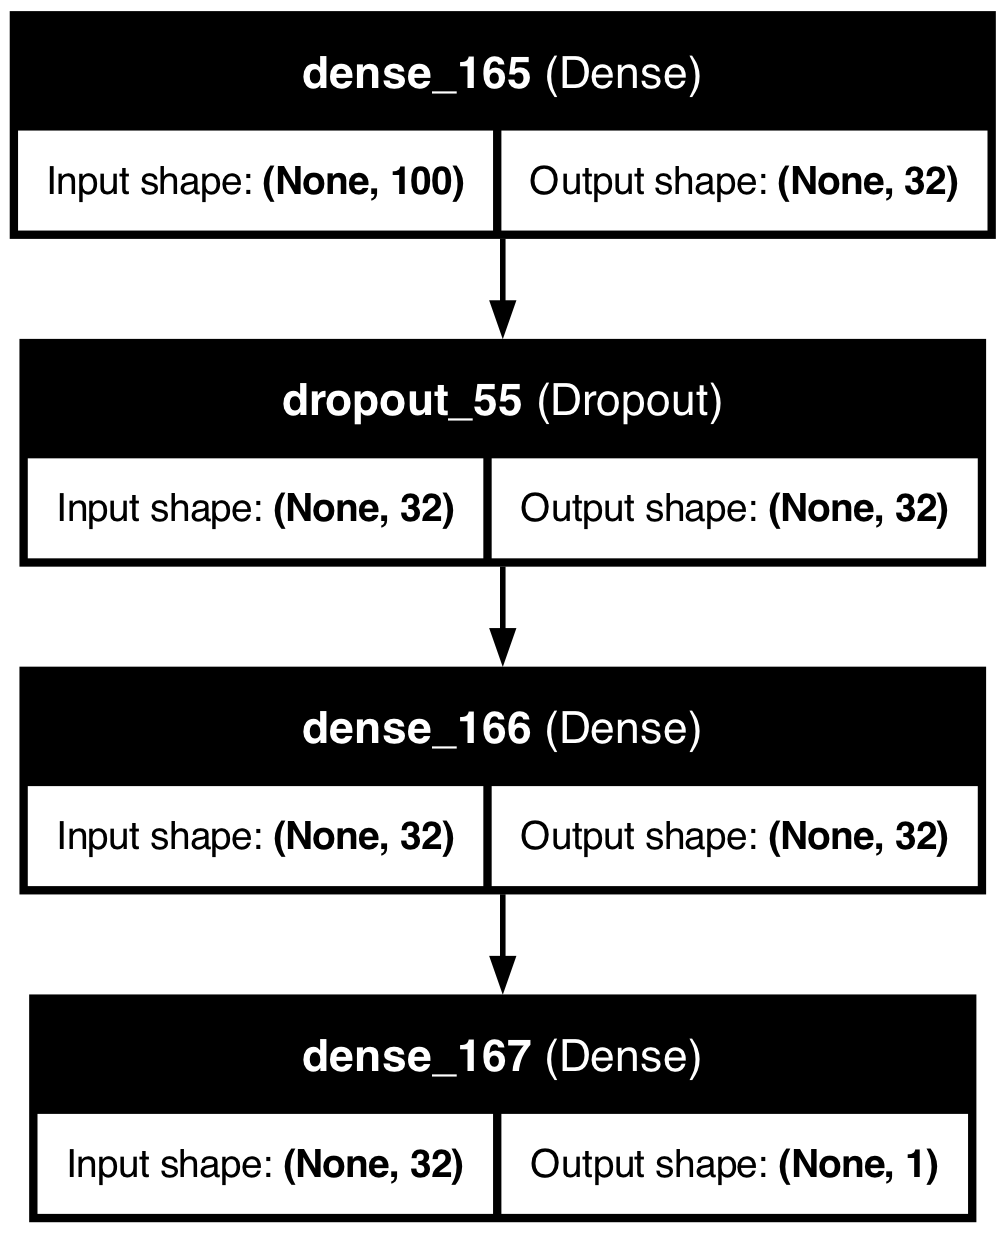

In [ ]:
# Generate the plot
plot_model(model_1c, show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model
model_1c.compile(
    optimizer=best_params['optimizer'],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=20, 
    verbose=1, 
    min_lr=0.001
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Fit the model
model_1c_history = model_1c.fit(
    cX_train_vec, cy_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/200
236/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7201 - loss: 0.5554
Epoch 1: val_loss improved from inf to 0.55056, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7199 - loss: 0.5554 - val_accuracy: 0.7228 - val_loss: 0.5506 - learning_rate: 0.0010
Epoch 2/200
213/248 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7113 - loss: 0.5596
Epoch 2: val_loss improved from 0.55056 to 0.55019, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7117 - loss: 0.5596 - val_accuracy: 0.7284 - val_loss: 0.5502 - learning_rate: 0.0010
Epoch 3/200
208/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7069 - loss: 0.5654
Epoch 3: val_loss improved from 0.55019 to 0.54979, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7077 - loss: 0.5643 - val_accuracy: 0.7284 - val_loss: 0.5498 - learning_rate: 0.0010
Epoch 4/200
223/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

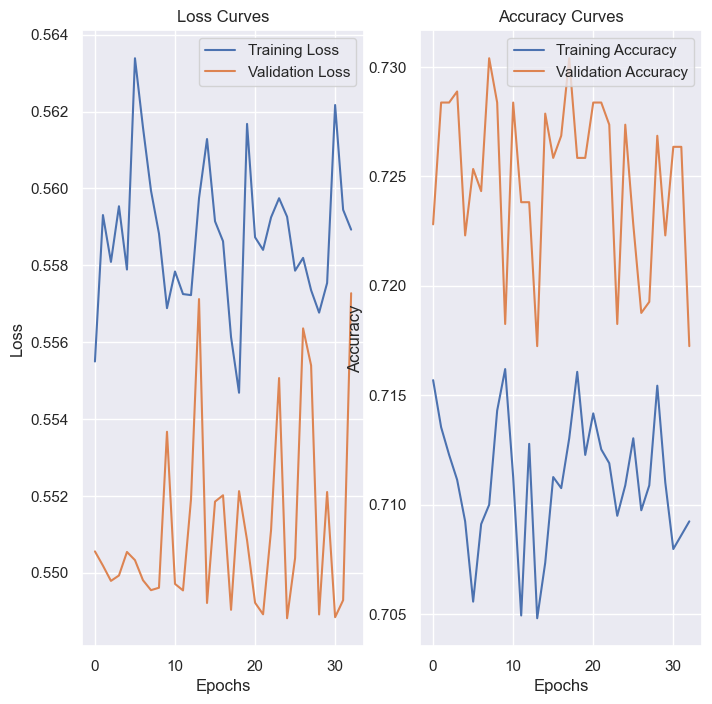

In [ ]:
# Create a function to vizuualize the training and validation loss and accuracy
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
    history: TensorFlow History object.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Use the function with your model's history
plot_loss_curves(model_1c_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1c.predict(cX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1c_time_per_instance = (end_time - start_time) / len(cX_test_vec)

# Calculate accuracy, precision, recall, and f1 score
m1c_accuracy = accuracy_score(cy_test, cy_pred)
m1c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1c_recall = recall_score(cy_test, cy_pred, average='weighted')
m1c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1c_accuracy:.2%}", f"{m1c_precision:.3f}", f"{m1c_recall:.3f}", f"{m1c_f1:.3f}", f"{m1c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Performance          Results
         accuracy           72.33%
        precision            0.729
           recall            0.723
         f1_score            0.722
    time/instance 0.000169 seconds


In [ ]:
store_results('Model_1c', m1c_accuracy, m1c_precision, m1c_recall, m1c_f1, m1c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds


#### FNN with raw data

In [ ]:
# Define the model building function without compile arguments
def create_model(neurons=64, dropout_rate=0.5, activation='relu'):
    model = Sequential([
        Dense(neurons, activation=activation, input_shape=(rX_train_vec.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

# Wrap the model with KerasClassifier and include compile-time parameters
model = KerasClassifier(model=create_model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the grid search parameters
param_grid = {
    'model__neurons': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.3, 0.5],
    'model__activation': ['sigmoid'],
    'optimizer': ['rmsprop','Nadam']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Fit GridSearchCV
grid_result = grid.fit(rX_train_vec, ry_train)  

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.5067 - loss: 0.6940
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.5393 - loss: 0.6900
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.5205 - loss: 0.6979
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step - accuracy: 0.5149 - loss: 0.6952
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5236 - loss: 0.6940
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 974us/step - accuracy: 0.5220 - loss: 0.6984
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.5150 - loss: 0.6952
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.5106 - loss: 0.7021
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.5249 - loss: 0.6963
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5202 - loss: 0.6988
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5225 - loss: 0.6922
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5350 - loss: 0.6896
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5078 - loss: 0.6982
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5231 - loss: 0.6948
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5163 - loss: 0.6977
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5223 - loss: 0.7133
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5278 - loss: 0.6932
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5382 - loss: 0.7040
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.5262 - loss: 0.6924
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.5147 - loss: 0.7165
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5224 - loss: 0.6924
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - accuracy: 0.5263 - loss: 0.7181
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5101 - loss: 0.6940
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5123 - loss: 0.7054
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5132 - loss: 0.6944
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.4959 - loss: 0.6969
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.5174 - loss: 0.6940
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5267 - loss: 0.6995
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5089 - loss: 0.6941
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5351 - loss: 0.6900
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5089 - loss: 0.7013
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5192 - loss: 0.6989
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5113 - loss: 0.6986
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5113 - loss: 0.6938
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5354 - loss: 0.7001
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5352 - loss: 0.6938
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - accuracy: 0.5083 - loss: 0.6964
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5151 - loss: 0.6984
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4980 - loss: 0.7039
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5101 - loss: 0.6958
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5062 - loss: 0.7737
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5119 - loss: 0.6973
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5143 - loss: 0.7034
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.5149 - loss: 0.6937
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.5072 - loss: 0.7050
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5193 - loss: 0.6957
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5267 - loss: 0.7012
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5047 - loss: 0.6954
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5128 - loss: 0.7022
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5084 - loss: 0.7021
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5109 - loss: 0.6978
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5138 - loss: 0.7008
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5313 - loss: 0.6921
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5299 - loss: 0.6923
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5276 - loss: 0.6899


In [ ]:
# Print best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.624949 using {'model__activation': 'sigmoid', 'model__dropout_rate': 0.3, 'model__neurons': 32, 'optimizer': 'Nadam'}


In [ ]:
best_params = grid_result.best_params_

# Create the final model using the best parameters
model_1r = create_model(
    neurons=best_params['model__neurons'],
    dropout_rate=best_params['model__dropout_rate'],
    activation=best_params['model__activation']
)

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Generate the plot
plot_model(model_1r, show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model
model_1r.compile(
    optimizer=best_params['optimizer'],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=20, 
    verbose=1, 
    min_lr=0.001
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Fit the model
model_1r_history = model_1r.fit(
    rX_train_vec, ry_train,
    epochs=300,
    batch_size=32,
    validation_split=0.2, 
    callbacks=[early_stopping, reduce_lr, checkpoint], # Using 20% of the training data as validation data,
    verbose=1
)

Epoch 1/300
244/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5272 - loss: 0.6932
Epoch 1: val_loss improved from inf to 0.67419, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5276 - loss: 0.6930 - val_accuracy: 0.5862 - val_loss: 0.6742 - learning_rate: 0.0010
Epoch 2/300
232/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5800 - loss: 0.6727
Epoch 2: val_loss improved from 0.67419 to 0.65666, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5807 - loss: 0.6724 - val_accuracy: 0.6216 - val_loss: 0.6567 - learning_rate: 0.0010
Epoch 3/300
235/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6069 - loss: 0.6578
Epoch 3: val_loss improved from 0.65666 to 0.64731, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6068 - loss: 0.6578 - val_accuracy: 0.6292 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 4/300
208/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 

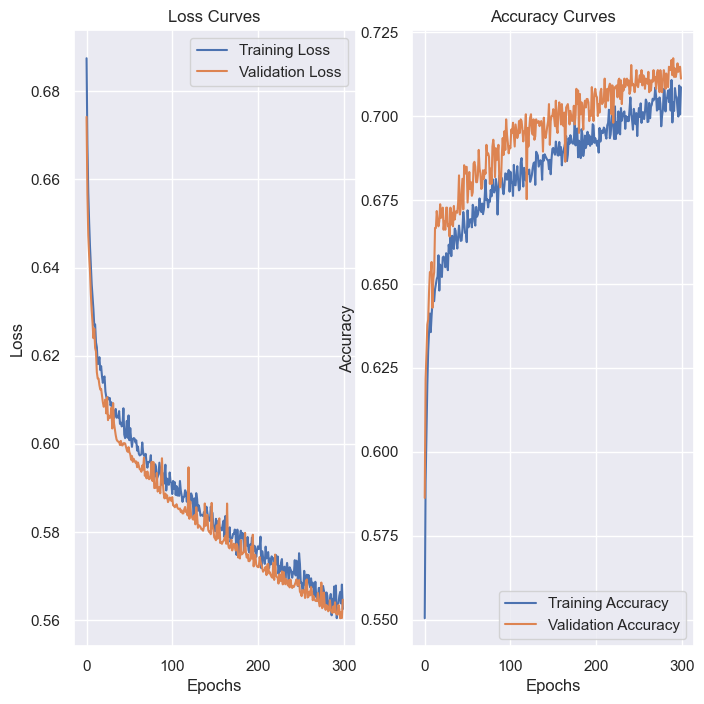

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_1r_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1r.predict(rX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1r_time_per_instance = (end_time - start_time) / len(rX_test_vec)

# Calculate accuracy, precision, recall, and f1 score
m1r_accuracy = accuracy_score(ry_test, ry_pred)
m1r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1r_recall = recall_score(ry_test, ry_pred, average='weighted')
m1r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1r_accuracy:.2%}", f"{m1r_precision:.3f}", f"{m1r_recall:.3f}", f"{m1r_f1:.3f}", f"{m1r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Performance          Results
         accuracy           70.75%
        precision            0.715
           recall            0.708
         f1_score            0.705
    time/instance 0.000131 seconds


In [ ]:
store_results('Model_1r', m1r_accuracy, m1r_precision, m1r_recall, m1r_f1, m1r_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds
13  Model_1r   70.75%     0.715  0.708    0.705  0.000131 seconds


In [ ]:
stop

NameError: name 'stop' is not defined

### LSTM (single layer)

My second model is a LSTM with a single layer

In [ ]:
# Reshape the data for LSTM: [samples, time steps, features]
cX_train_lstm = cX_train_vec.reshape(cX_train_vec.shape[0], 1, cX_train_vec.shape[1])
cX_test_lstm = cX_test_vec.reshape(cX_test_vec.shape[0], 1, cX_test_vec.shape[1])

rX_train_lstm = rX_train_vec.reshape(rX_train_vec.shape[0], 1, rX_train_vec.shape[1])
rX_test_lstm = rX_test_vec.reshape(rX_test_vec.shape[0], 1, rX_test_vec.shape[1])

#### LSTM (single layer) with cleaned data

In [ ]:
def create_model(lstm_units=50, learning_rate=0.01):
    model = Sequential([
        LSTM(units=lstm_units, input_shape=(1, 100)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier without specifying epochs or batch size here
model = KerasClassifier(build_fn=create_model, lstm_units=20, learning_rate=0.01, verbose=0)

# Define the grid search parameters
param_grid = {
    'lstm_units': [20, 50, 100],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'epochs': [10, 15]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(cX_train_lstm, cy_train)


# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


2024-05-12 18:45:24.775199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 18:45:24.775199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 18:45:24.775202: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 18:45:24.775203: I tensorflow/core/platform/cpu_featu

Best: 0.710946 using {'batch_size': 32, 'epochs': 15, 'learning_rate': 0.01, 'lstm_units': 100}
0.680795 (0.013430) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 20}
0.658535 (0.030390) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 50}
0.666428 (0.022614) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 100}
0.679279 (0.009029) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 20}
0.678670 (0.023708) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 50}
0.694557 (0.004888) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 100}
0.620598 (0.014621) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'lstm_units': 20}
0.593683 (0.025962) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'lstm_units': 50}
0.624848 (0.007581) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'lstm_units

In [ ]:
best_params = grid_result.best_params_
best_lstm_units = best_params['lstm_units']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']

In [ ]:
# Create the model with the best parameters found
model_2c = create_model(best_lstm_units, best_learning_rate)

# Model Summary
print(model_2c.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_337"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1009 (Dense)              │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,501 (314.46 KB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 0 (0.00 B)

None


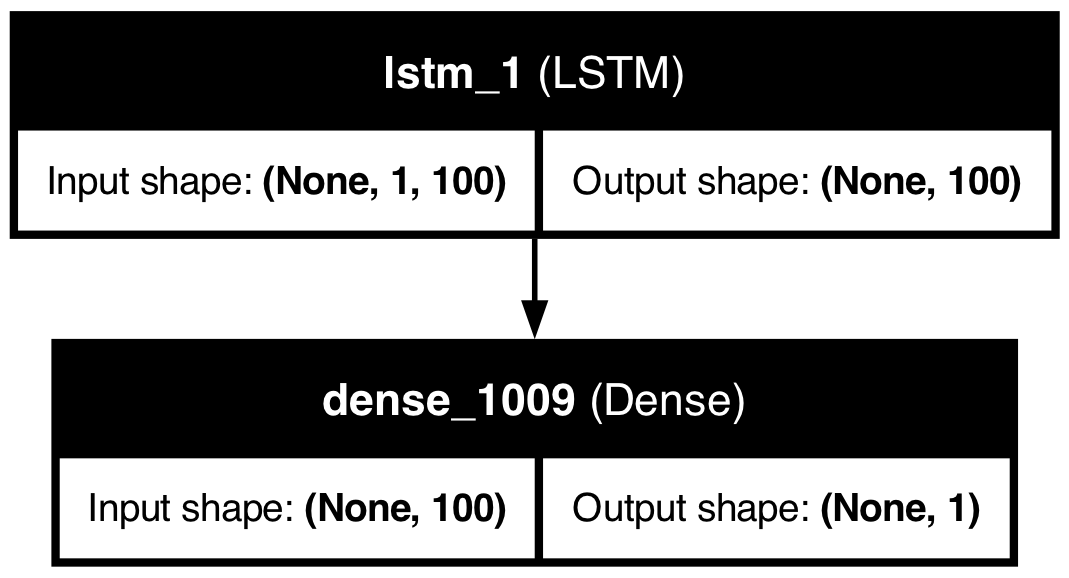

In [ ]:
# Generate the plot
plot_model(model_2c, show_shapes=True, show_layer_names=True)

In [ ]:
# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=25, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=20, 
    verbose=1, 
    min_lr=0.001
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Fit the model
model_2c_history = model_2c.fit(
    cX_train_lstm, cy_train,
    epochs=300,
    batch_size=best_batch_size,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/300
230/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4995 - loss: 0.6994
Epoch 1: val_loss improved from inf to 0.69112, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5001 - loss: 0.6990 - val_accuracy: 0.5422 - val_loss: 0.6911 - learning_rate: 0.0100
Epoch 2/300
237/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5304 - loss: 0.6893
Epoch 2: val_loss did not improve from 0.69112
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5313 - loss: 0.6892 - val_accuracy: 0.5013 - val_loss: 0.7002 - learning_rate: 0.0100
Epoch 3/300
224/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5714 - loss: 0.6775
Epoch 3: val_loss improved from 0.69112 to 0.65534, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5736 - loss: 0.6768 - val_accuracy: 0.6282 - val_loss: 0.6553 - learning_rate: 0.0100
Epoch 4/300
240/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6265 - loss: 0.6598
Epoch 4: val_los

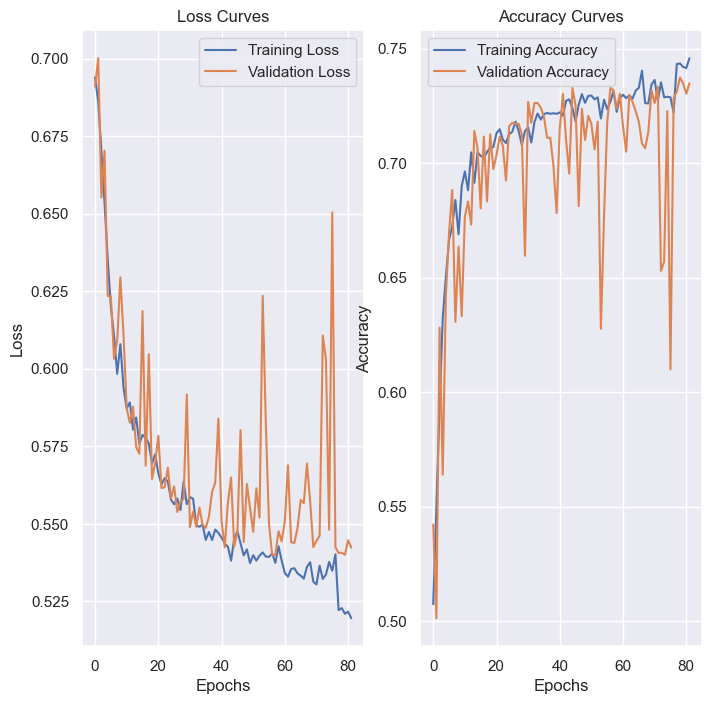

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_2c_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_2c.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2c_time_per_instance = (end_time - start_time) / len(cX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m2c_accuracy = accuracy_score(cy_test, cy_pred)
m2c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2c_recall = recall_score(cy_test, cy_pred, average='weighted')
m2c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2c_accuracy:.2%}", f"{m2c_precision:.3f}", f"{m2c_recall:.3f}", f"{m2c_f1:.3f}", f"{m2c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Model Performance          Results
         accuracy           72.86%
        precision            0.732
           recall            0.729
         f1_score            0.728
    time/instance 0.000529 seconds


In [ ]:
store_results('Model_2c', m2c_accuracy, m2c_precision, m2c_recall, m2c_f1, m2c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds
13  Model_1r   70.75%     0.715  0.708    0.705  0.000131 seconds
14  Model_

#### LSTM (single layer) with raw data

In [ ]:
grid_result = grid.fit((rX_train_lstm), ry_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will rais

Best: 0.698301 using {'batch_size': 32, 'epochs': 15, 'learning_rate': 0.01, 'lstm_units': 20}
0.690611 (0.000966) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 20}
0.681607 (0.004810) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 50}
0.686463 (0.002473) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 100}
0.669567 (0.012522) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 20}
0.670883 (0.013433) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 50}
0.672704 (0.011798) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 100}
0.631324 (0.001566) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'lstm_units': 20}
0.641238 (0.004104) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'lstm_units': 50}
0.645083 (0.007456) with: {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'lstm_units'

In [ ]:
best_params = grid_result.best_params_
best_lstm_units = best_params['lstm_units']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']

In [ ]:
# Create the model with the best parameters found
model_2r = create_model(best_lstm_units, best_learning_rate)

# Model Summary
print(model_2r.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_339"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 20)             │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1011 (Dense)              │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,701 (37.89 KB)

 Trainable params: 9,701 (37.89 KB)

 Non-trainable params: 0 (0.00 B)

None


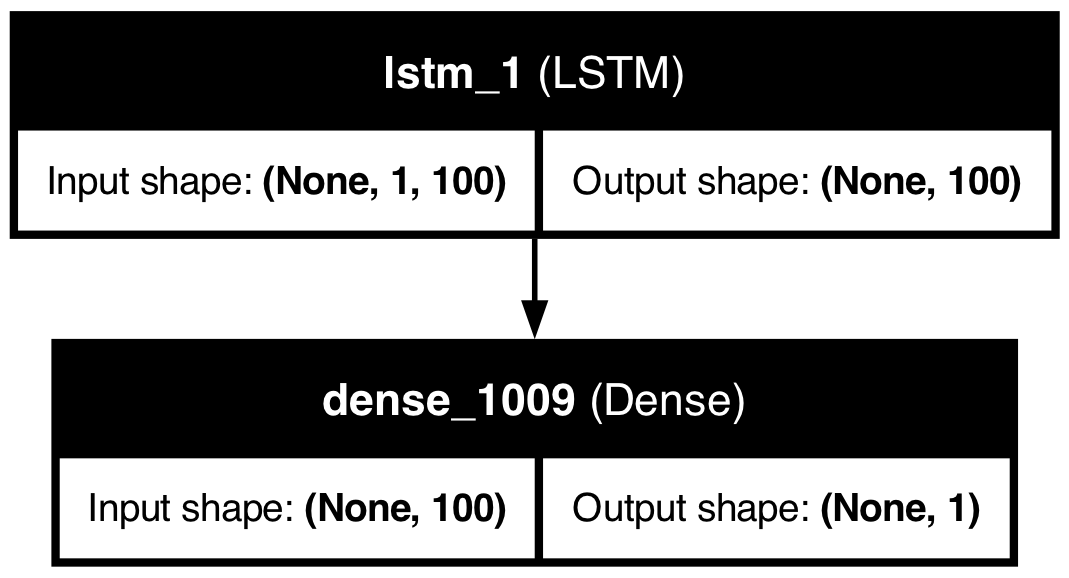

In [ ]:
# Generate the plot
plot_model(model_2c, show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history = model_2r.fit(rX_train_lstm, ry_train, epochs=300, batch_size=best_batch_size, validation_split=0.2,)

Epoch 1/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7129 - loss: 0.5471 - val_accuracy: 0.7137 - val_loss: 0.5624
Epoch 2/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7251 - loss: 0.5395 - val_accuracy: 0.7152 - val_loss: 0.5567
Epoch 3/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7137 - loss: 0.5436 - val_accuracy: 0.7167 - val_loss: 0.5462
Epoch 4/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7237 - loss: 0.5350 - val_accuracy: 0.7127 - val_loss: 0.5623
Epoch 5/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7173 - loss: 0.5417 - val_accuracy: 0.7248 - val_loss: 0.5453
Epoch 6/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7176 - loss: 0.5402 - val_accuracy: 0.7198 - val_loss: 0.5472
Epoch 7/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7231 - loss: 0.5347 - val_accuracy: 0.7142 - val_loss: 0.5501
Epoch 8/300
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7267 - loss: 0.5311 - val_accu

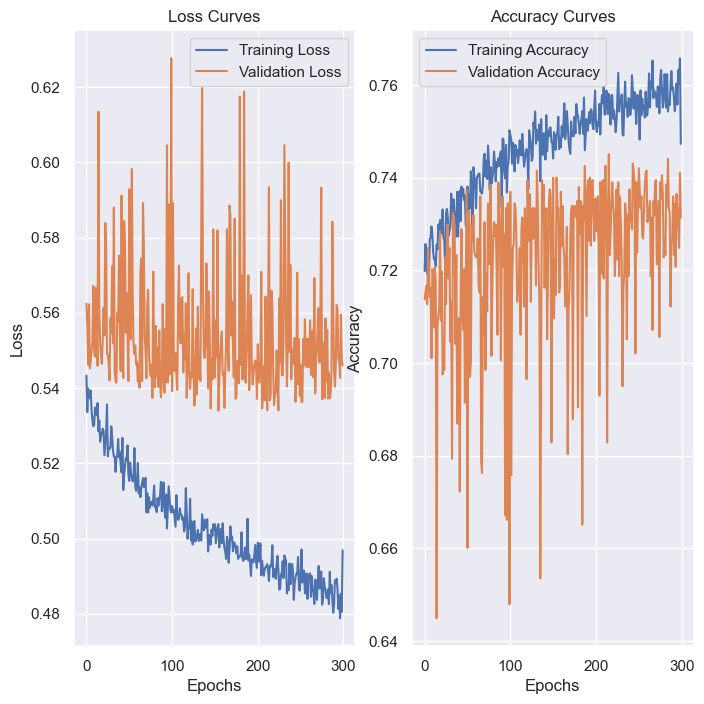

In [ ]:
# Use the function with your model's history 
plot_loss_curves(history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_2r.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2r_time_per_instance = (end_time - start_time) / len(rX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m2r_accuracy = accuracy_score(ry_test, ry_pred)
m2r_precision = precision_score(ry_test, ry_pred, average='weighted')
m2r_recall = recall_score(ry_test, ry_pred, average='weighted')
m2r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2r_accuracy:.2%}", f"{m2r_precision:.3f}", f"{m2r_recall:.3f}", f"{m2r_f1:.3f}", f"{m2r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance          Results
         accuracy           72.45%
        precision            0.733
           recall            0.725
         f1_score            0.722
    time/instance 0.000158 seconds


In [ ]:
store_results('Model_2r', m2r_accuracy, m2r_precision, m2r_recall, m2r_f1, m2r_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds
13  Model_1r   70.75%     0.715  0.708    0.705  0.000131 seconds
14  Model_

### LSTM (stacked) with cleaned and raw data

Now I use another LSTM (stacked)

#### LSTM (stacked) with cleaned data

In [ ]:
# Define the model building function
def create_model(lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(1, cX_train_vec.shape[1])))  
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=create_model, dropout_rate=0.1, lstm_units=50,verbose=0)

# Define the grid search parameters
param_grid = {
    'lstm_units': [50, 100, 150],  # LSTM units
    'dropout_rate': [0.1, 0.2, 0.3],  # Dropout rates
    'batch_size': [32, 64],  # Batch sizes
    'epochs': [20]  # Number of epochs
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

grid_result = grid.fit(cX_train_lstm, cy_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

2024-05-12 19:09:49.186375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 19:09:49.186380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 19:09:49.186388: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 19:09:49.186374: I tensorflow/core/platform/cpu_featu

Best: 0.715904 using {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 150}
0.710035 (0.013925) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 50}
0.714285 (0.007609) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 100}
0.704675 (0.009897) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 150}
0.705383 (0.007587) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 50}
0.712970 (0.005031) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 100}
0.681609 (0.026197) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 150}
0.700118 (0.020599) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 50}
0.709834 (0.001028) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 100}
0.703359 (0.008989) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 150}
0.709934 (0.011868

In [ ]:
# Store the best parameters
best_params = grid_result.best_params_
best_lstm_units = best_params['lstm_units']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = grid_result.best_params_['batch_size']

In [ ]:
# Create the model with the best parameters found
model_3c = create_model(best_lstm_units, best_dropout_rate)

# Model Summary
print(model_3c.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_341"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 1, 150)         │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_339 (Dropout)           │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 150)         │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_340 (Dropout)           │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_341 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1013 (Dense)              │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511,951 (1.95 MB)

 Trainable params: 511,951 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

None


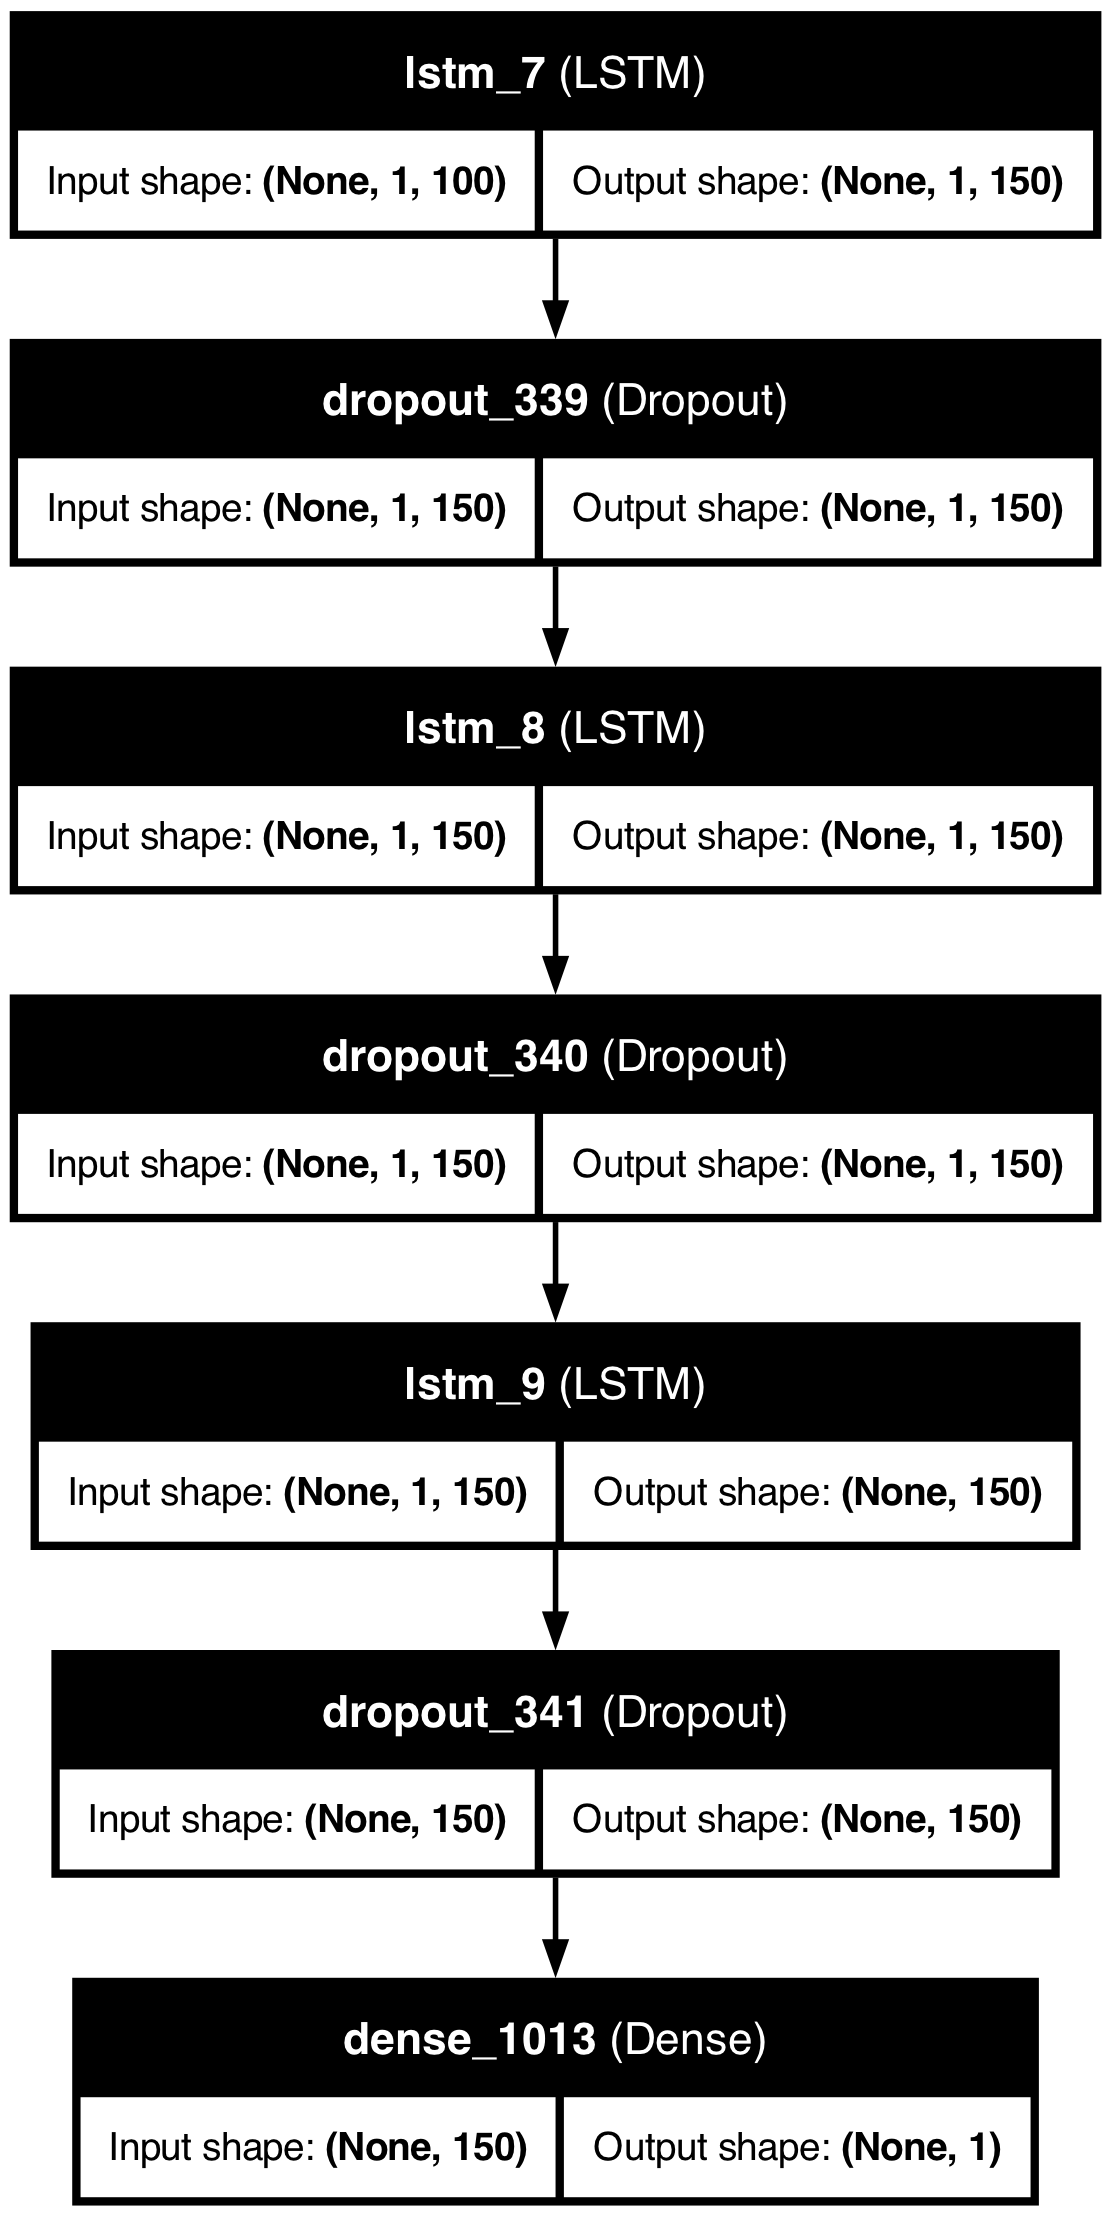

In [ ]:
# Generate the plot
plot_model(model_3c, show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
model_3c_history= model_3c.fit(cX_train_lstm, cy_train, epochs=300, batch_size=best_batch_size, validation_split=0.2)

Epoch 1/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.4988 - loss: 0.6935 - val_accuracy: 0.5164 - val_loss: 0.6926
Epoch 2/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5249 - loss: 0.6916 - val_accuracy: 0.6181 - val_loss: 0.6760
Epoch 3/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5888 - loss: 0.6753 - val_accuracy: 0.5721 - val_loss: 0.6664
Epoch 4/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5983 - loss: 0.6650 - val_accuracy: 0.5898 - val_loss: 0.6519
Epoch 5/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6204 - loss: 0.6527 - val_accuracy: 0.6657 - val_loss: 0.6247
Epoch 6/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6377 - loss: 0.6437 - val_accuracy: 0.6490 - val_loss: 0.6110
Epoch 7/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6744 - loss: 0.6140 - val_accuracy: 0.6737 - val_loss: 0.5970
Epoch 8/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6657 - loss: 0.6100 - v

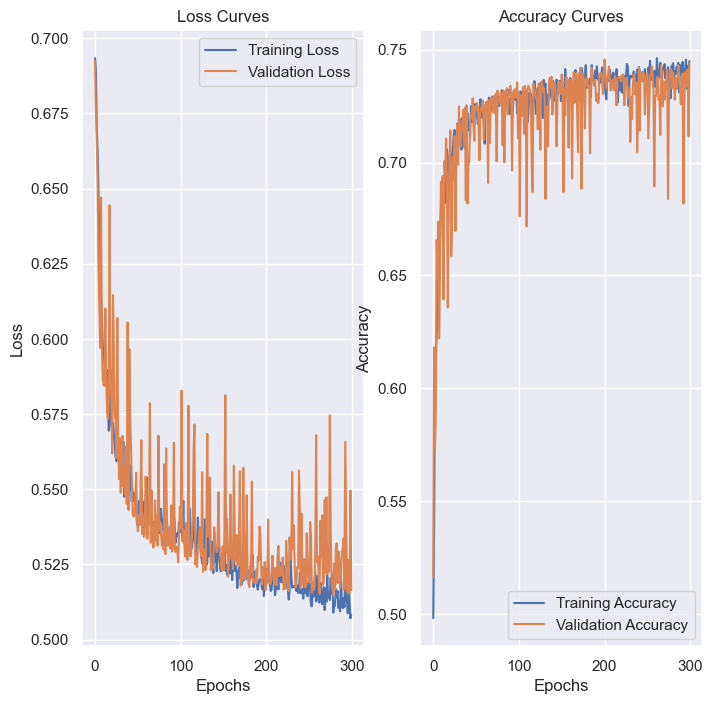

In [ ]:
plot_loss_curves(model_3c_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_3c.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3c_time_per_instance = (end_time - start_time) / len(cX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m3c_accuracy = accuracy_score(cy_test, cy_pred)
m3c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m3c_recall = recall_score(cy_test, cy_pred, average='weighted')
m3c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3c_accuracy:.2%}", f"{m3c_precision:.3f}", f"{m3c_recall:.3f}", f"{m3c_f1:.3f}", f"{m3c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Model Performance          Results
         accuracy           74.19%
        precision            0.747
           recall            0.742
         f1_score            0.741
    time/instance 0.001068 seconds


In [ ]:
store_results('Model_3c', m3c_accuracy, m3c_precision, m3c_recall, m3c_f1, m3c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds
13  Model_1r   70.75%     0.715  0.708    0.705  0.000131 seconds
14  Model_

#### LSTM (stacked) with raw data

In [ ]:
# Evaluate the best model
grid_result = grid.fit(rX_train_lstm, ry_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

2024-05-12 19:25:02.241174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 19:25:02.241979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 19:25:02.246440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 19:25:02.247262: I tensorflow/core/platform/cpu_featu

Best: 0.699312 using {'batch_size': 64, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 150}
0.693242 (0.003646) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 50}
0.694252 (0.012351) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 100}
0.682110 (0.021113) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 150}
0.697389 (0.006892) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 50}
0.695973 (0.003172) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 100}
0.691319 (0.011734) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 150}
0.696580 (0.008604) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 50}
0.692937 (0.009267) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 100}
0.696074 (0.004388) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 150}
0.690409 (0.002861

In [ ]:
# Store the best parameters
best_params = grid_result.best_params_
best_lstm_units = best_params['lstm_units']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = grid_result.best_params_['batch_size']

In [ ]:
# Create the model with the best parameters found
model_3r = create_model(best_lstm_units, best_dropout_rate)

# Model Summary
print(model_3c.summary())

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_341"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 1, 150)         │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_339 (Dropout)           │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 150)         │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_340 (Dropout)           │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_341 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1013 (Dense)              │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535,855 (5.86 MB)

 Trainable params: 511,951 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,023,904 (3.91 MB)

None


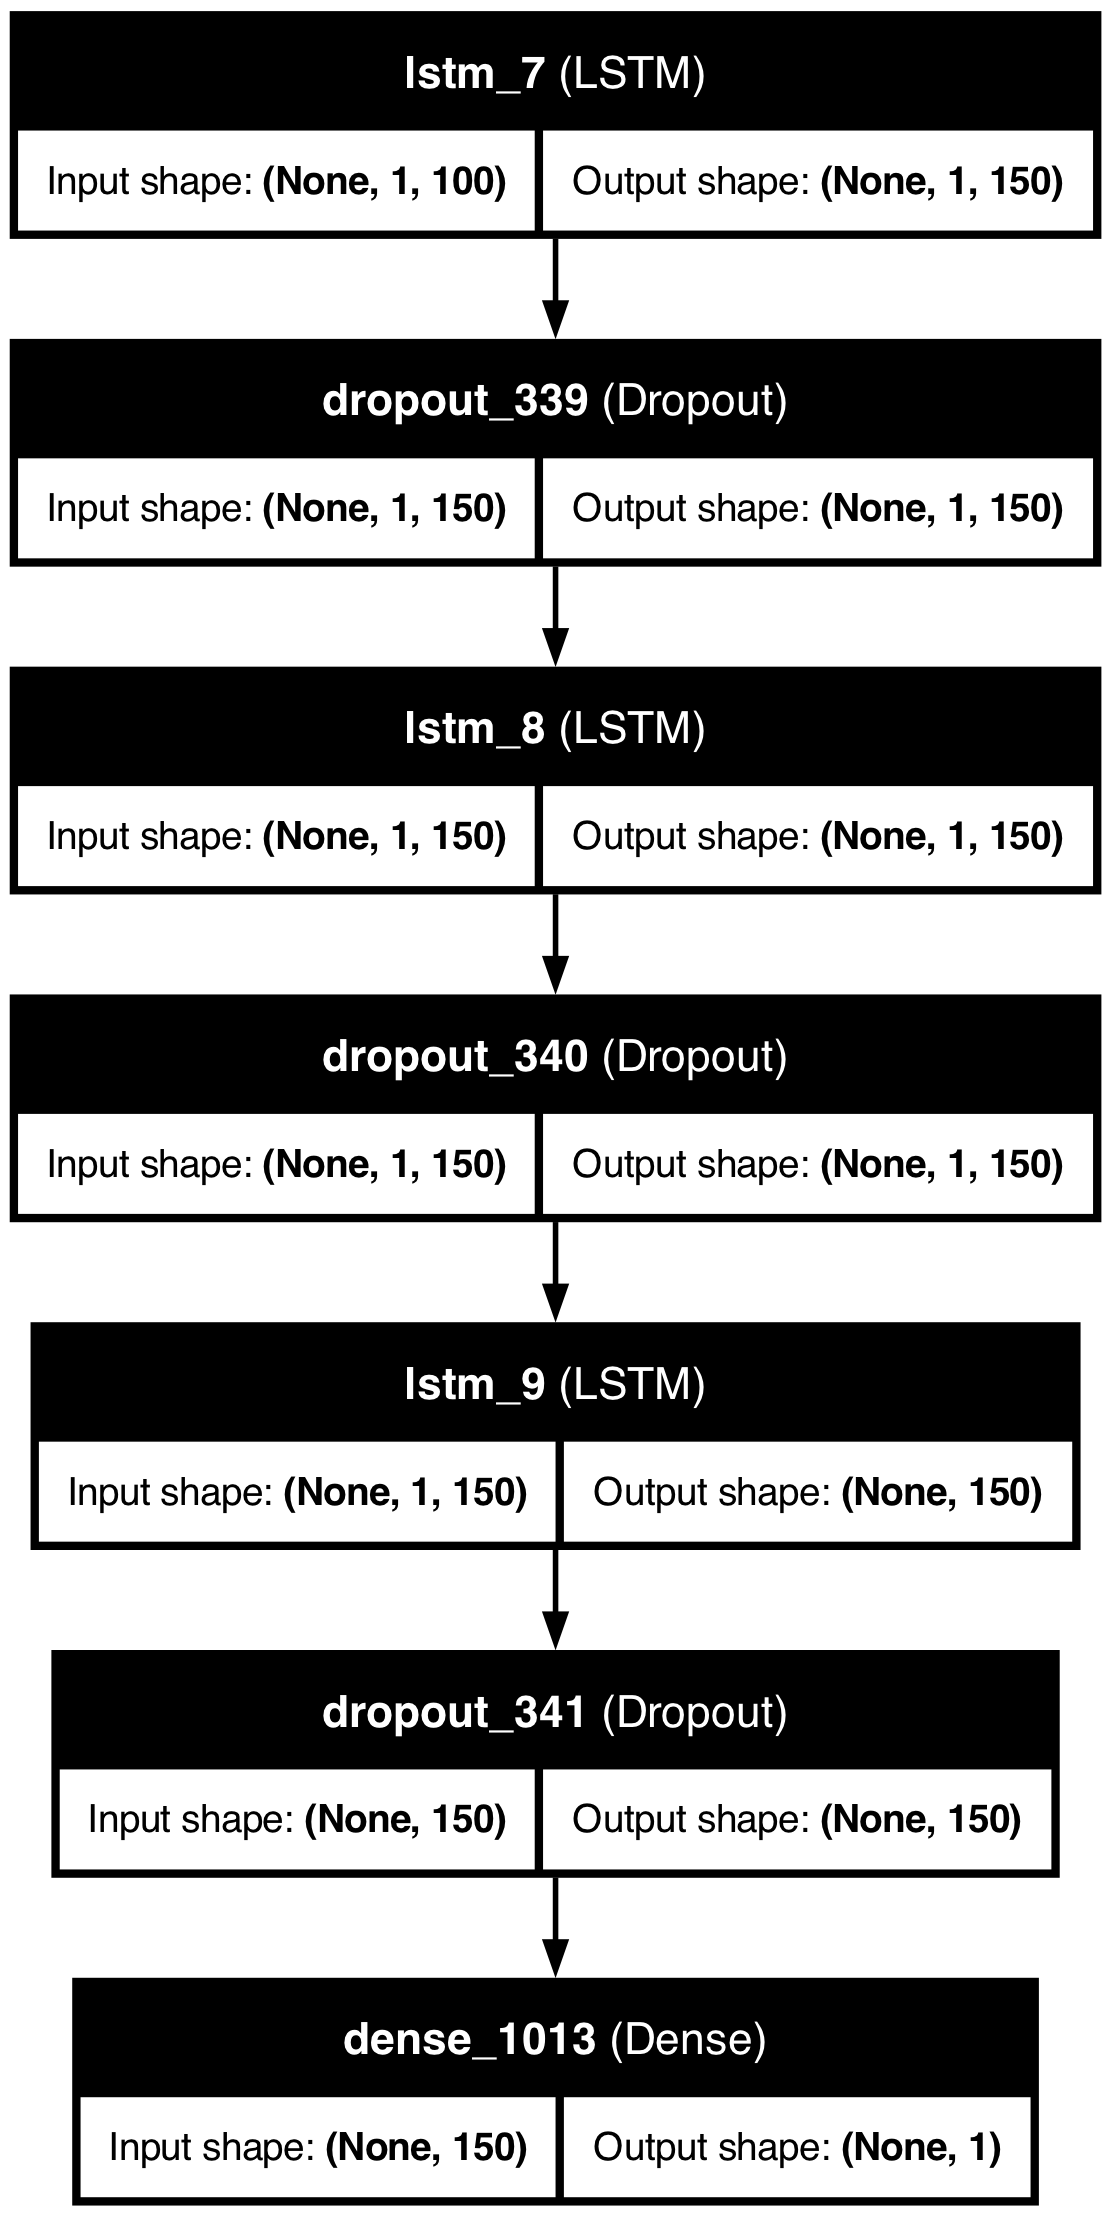

In [ ]:
# Generate the plot
plot_model(model_3c, show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
model_3r_history=model_3r.fit(rX_train_lstm, ry_train, epochs=300, batch_size=best_batch_size, validation_split=0.2)

Epoch 1/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.5729 - loss: 0.6752 - val_accuracy: 0.6388 - val_loss: 0.6377
Epoch 2/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6467 - loss: 0.6299 - val_accuracy: 0.6419 - val_loss: 0.6272
Epoch 3/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6564 - loss: 0.6164 - val_accuracy: 0.6732 - val_loss: 0.6054
Epoch 4/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6592 - loss: 0.6091 - val_accuracy: 0.6646 - val_loss: 0.6115
Epoch 5/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6676 - loss: 0.6073 - val_accuracy: 0.6707 - val_loss: 0.6007
Epoch 6/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6730 - loss: 0.5959 - val_accuracy: 0.6722 - val_loss: 0.5995
Epoch 7/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6718 - loss: 0.5971 - val_accuracy: 0.6758 - val_loss: 0.5995
Epoch 8/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6778 - loss: 0.5937 - val

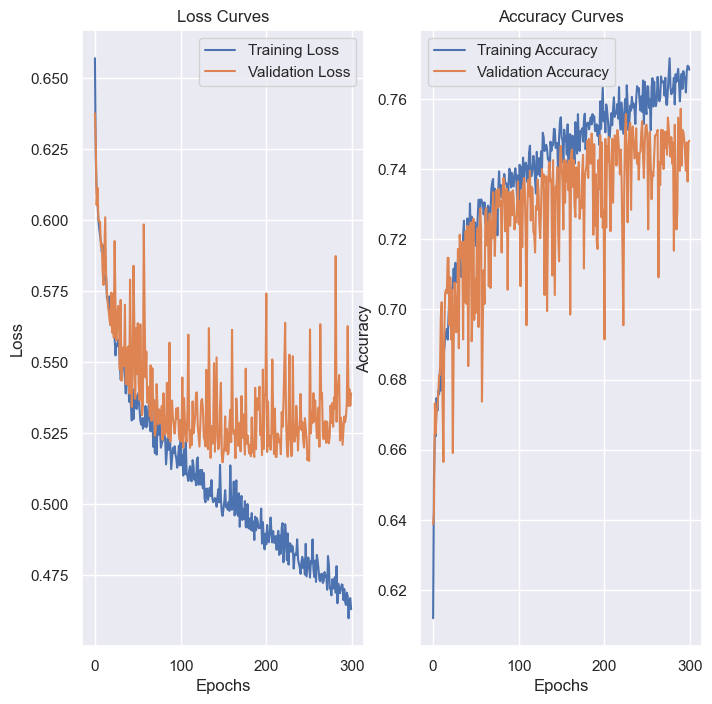

In [ ]:
plot_loss_curves(model_3r_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_3r.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3r_time_per_instance = (end_time - start_time) / len(rX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m3r_accuracy = accuracy_score(ry_test, ry_pred)
m3r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m3r_recall = recall_score(ry_test, ry_pred, average='weighted')
m3r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3r_accuracy:.2%}", f"{m3r_precision:.3f}", f"{m3r_recall:.3f}", f"{m3r_f1:.3f}", f"{m3r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Model Performance          Results
         accuracy           72.45%
        precision            0.733
           recall            0.725
         f1_score            0.722
    time/instance 0.001315 seconds


In [ ]:
store_results('Model_3r', m3r_accuracy, m3r_precision, m3r_recall, m3r_f1, m3r_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds
13  Model_1r   70.75%     0.715  0.708    0.705  0.000131 seconds
14  Model_

### USE (Universal Sentence Encoder)

Here I will use the universal encoder from Google (USE)

In [ ]:
# Load the Universal Sentence Encoder from TensorFlow Hub
USE_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Precompute the embeddings for the training and test sets
rX_train_embeddings = USE_embedding(rX_train)
rX_test_embeddings = USE_embedding(rX_test)
cX_train_embeddings = USE_embedding(cX_train)
cX_test_embeddings = USE_embedding(cX_test)

#### USE with cleaned data

In [ ]:
# Define the model
model_4c = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddings.shape[1],)),
    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Using an optimizer with adaptive learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model_4c.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

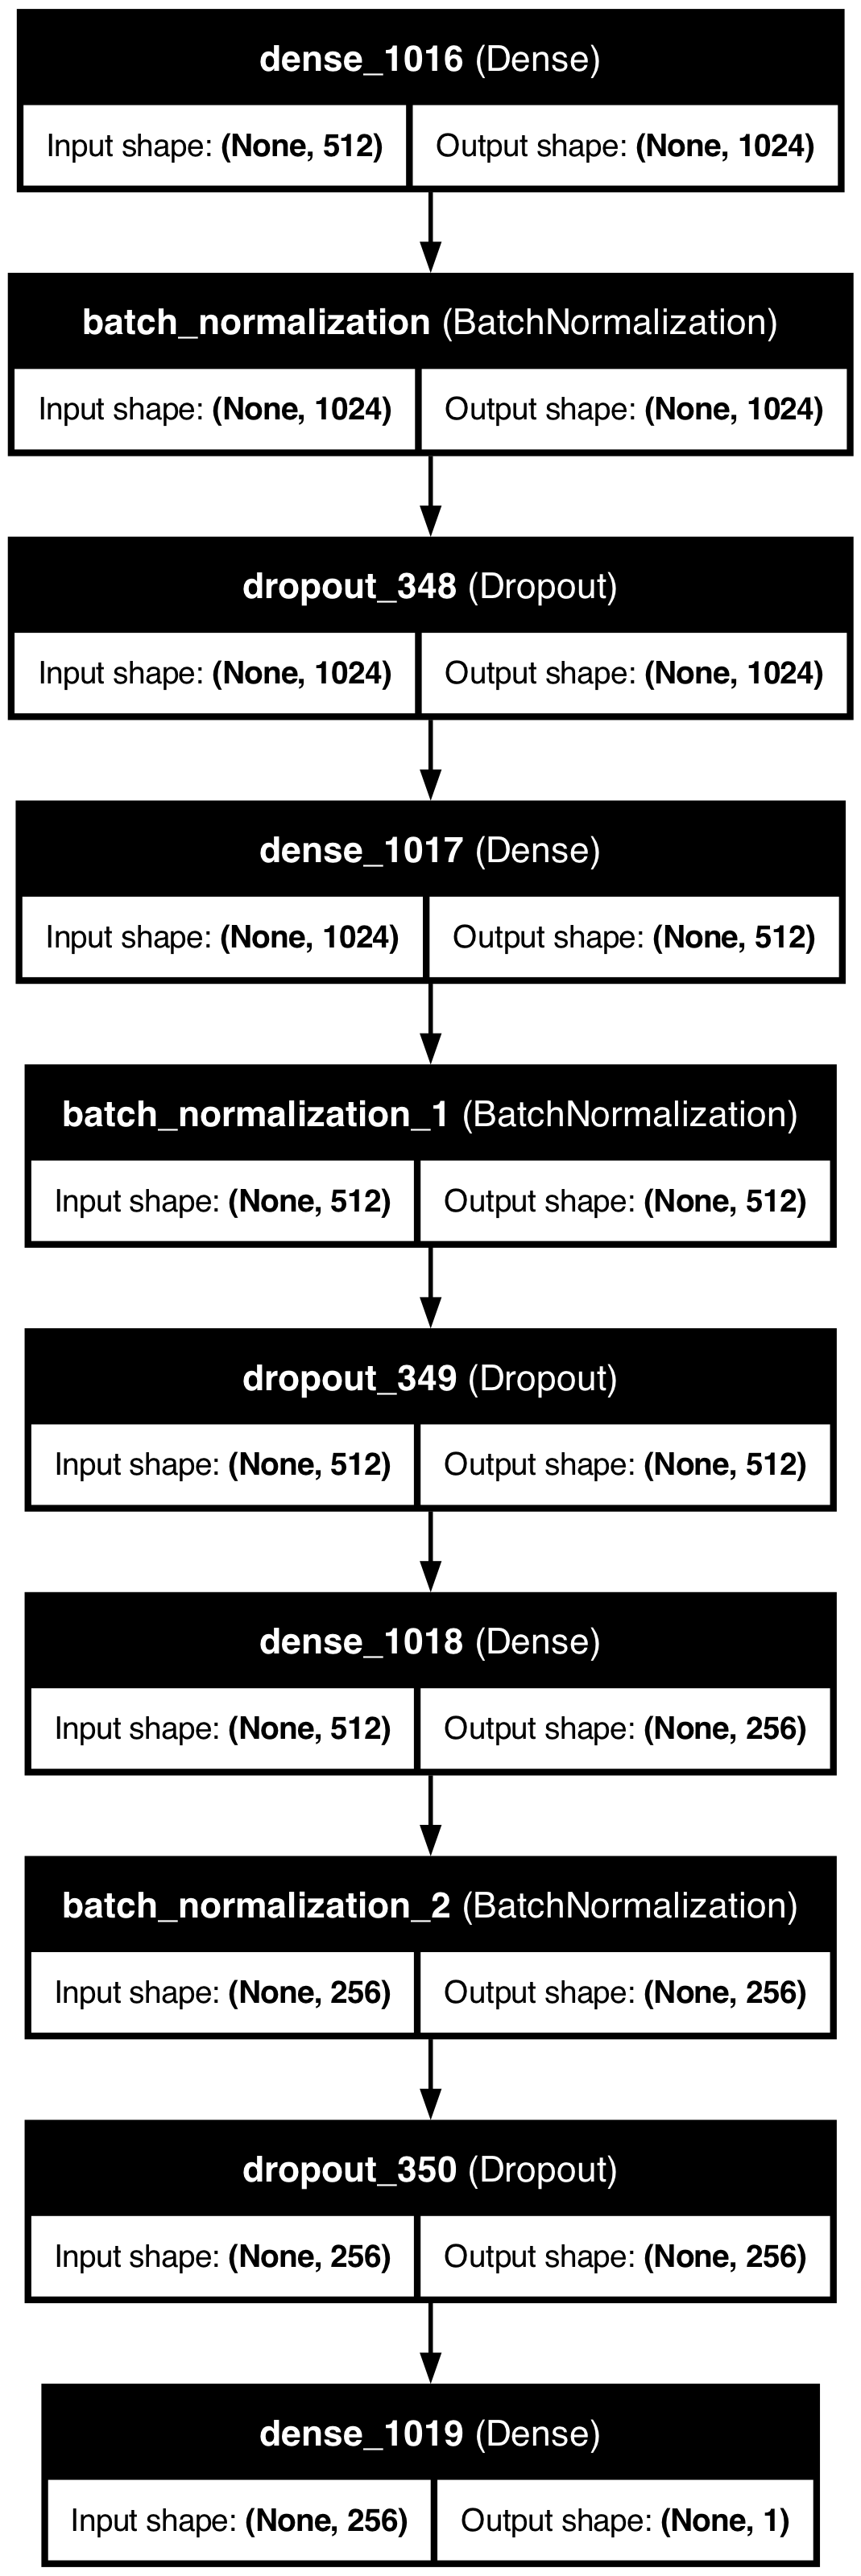

In [ ]:
# Generate the plot
plot_model(model_4c, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
epochs = 300

# Fit the model
model_4c_history = model_4c.fit(
    cX_train_embeddings, 
    cy_train, 
    batch_size=64, 
    epochs=epochs, 
    validation_split=0.2, 
    callbacks=[callback_es]
)

# Model Summary
print(model_4c.summary())

Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.5313 - loss: 2.7537 - val_accuracy: 0.4987 - val_loss: 2.4177
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5961 - loss: 2.5888 - val_accuracy: 0.4987 - val_loss: 2.4073
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6421 - loss: 2.5084 - val_accuracy: 0.5043 - val_loss: 2.3594
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6637 - loss: 2.4482 - val_accuracy: 0.6591 - val_loss: 2.2873
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6725 - loss: 2.4379 - val_accuracy: 0.7355 - val_loss: 2.2274
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6825 - loss: 2.4143 - val_accuracy: 0.7466 - val_loss: 2.2050
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6756 - loss: 2.4174 - val_accuracy: 0.7486 - val_loss: 2.2005
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6965 - loss: 2.4223 -

Model: "sequential_344"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1016 (Dense)              │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_348 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1017 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_349 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1018 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_350 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1019 (Dense)              │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,559,429 (13.58 MB)

 Trainable params: 1,185,281 (4.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 2,370,564 (9.04 MB)

None


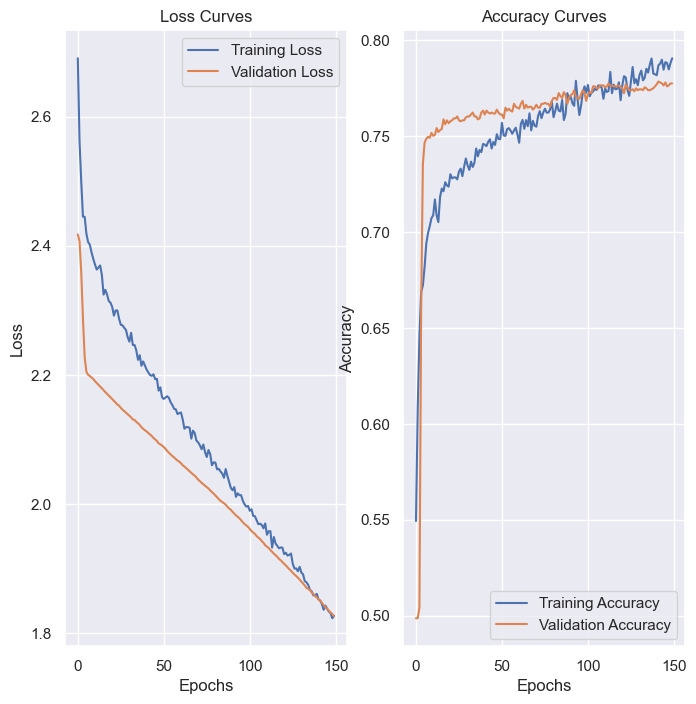

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_4c_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_4c.predict(cX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4c_time_per_instance = (end_time - start_time) / len(cX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4c_accuracy = accuracy_score(cy_test, cy_pred)
m4c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4c_recall = recall_score(cy_test, cy_pred, average='weighted')
m4c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4c_accuracy:.2%}", f"{m4c_precision:.3f}", f"{m4c_recall:.3f}", f"{m4c_f1:.3f}", f"{m4c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Model Performance          Results
         accuracy           77.91%
        precision            0.779
           recall            0.779
         f1_score            0.779
    time/instance 0.000591 seconds


In [ ]:
store_results('Model_4c', m4c_accuracy, m4c_precision, m4c_recall, m4c_f1, m4c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000004 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   70.79%     0.712  0.708    0.706  0.000130 seconds
3   Model_1r   60.40%     0.616  0.604    0.593  0.000116 seconds
4   Model_1r   61.77%     0.622  0.618    0.615  0.000137 seconds
5   Model_1r   71.08%     0.712  0.711    0.710  0.000191 seconds
6   Model_1c   71.93%     0.723  0.719    0.718  0.000129 seconds
7   Model_1r   60.44%     0.605  0.604    0.604  0.000211 seconds
8   Model_1c   71.80%     0.721  0.718    0.717  0.000108 seconds
9   Model_1r   60.52%     0.610  0.605    0.601  0.000090 seconds
10  Model_1c   72.25%     0.727  0.722    0.721  0.000170 seconds
11  Model_1r   60.15%     0.602  0.602    0.602  0.000139 seconds
12  Model_1c   72.33%     0.729  0.723    0.722  0.000169 seconds
13  Model_1r   70.75%     0.715  0.708    0.705  0.000131 seconds
14  Model_

#### USE with raw data

In [ ]:
# Define the model
model_4r = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(rX_train_embeddings.shape[1],)),
    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Using an optimizer with adaptive learning rate
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model_4r.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])

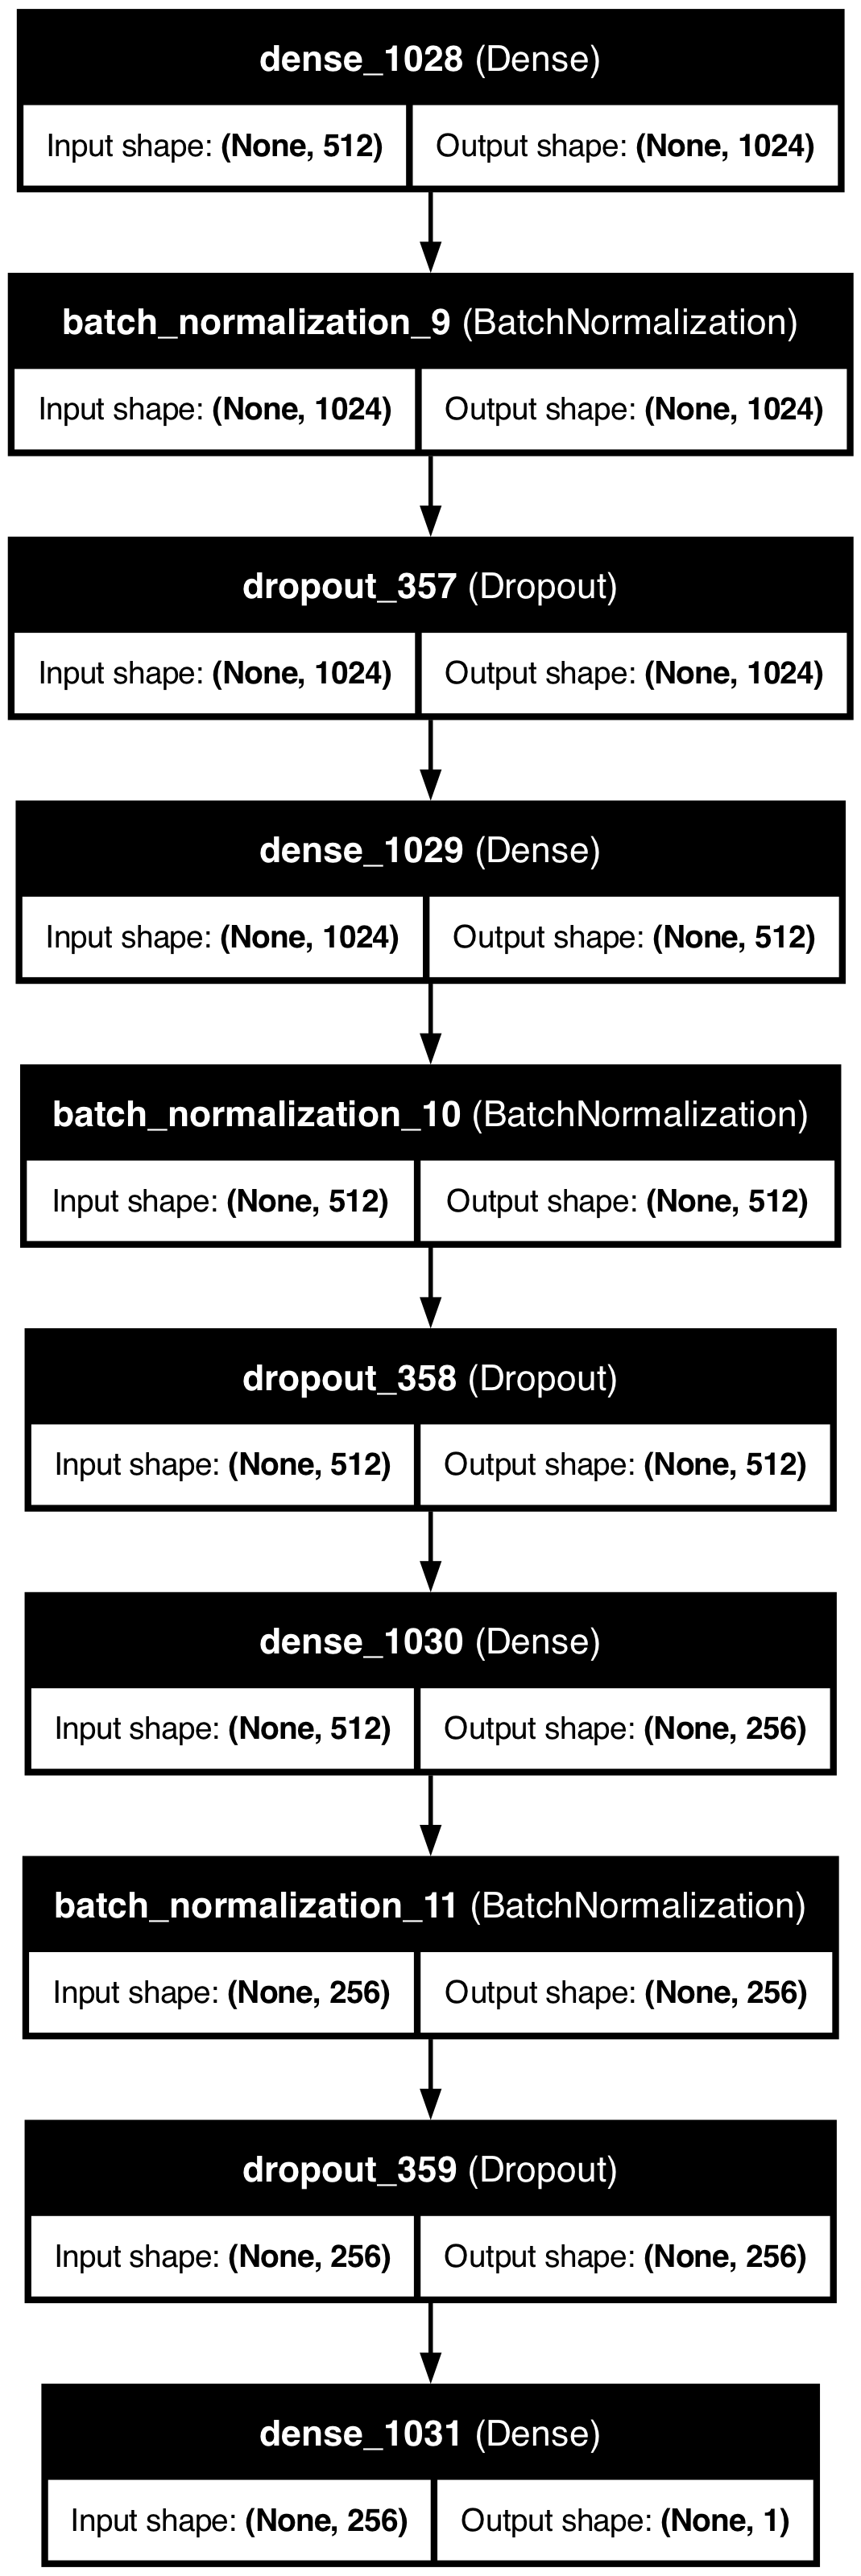

In [ ]:
# Generate the plot
plot_model(model_4r, show_shapes=True, show_layer_names=True)

In [ ]:
# Fit the model
model_4r_history = model_4r.fit(
    rX_train_embeddings, 
    ry_train, 
    batch_size=64, 
    epochs=epochs, 
    validation_split=0.2, 
    callbacks=[callback_es]
)

# Model Summary
print(model_4r.summary())

Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5303 - loss: 2.7131 - val_accuracy: 0.6889 - val_loss: 2.3888
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5912 - loss: 2.5780 - val_accuracy: 0.7329 - val_loss: 2.3604
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6432 - loss: 2.4692 - val_accuracy: 0.7461 - val_loss: 2.3098
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6734 - loss: 2.4288 - val_accuracy: 0.7582 - val_loss: 2.2425
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6663 - loss: 2.4359 - val_accuracy: 0.7658 - val_loss: 2.1859
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6874 - loss: 2.4056 - val_accuracy: 0.7719 - val_loss: 2.1627
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7024 - loss: 2.3699 - val_accuracy: 0.7754 - val_loss: 2.1576
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6986 - loss: 2.3776 -

Model: "sequential_347"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1028 (Dense)              │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_357 (Dropout)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1029 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_358 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_359 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1031 (Dense)              │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,559,429 (13.58 MB)

 Trainable params: 1,185,281 (4.52 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 2,370,564 (9.04 MB)

None


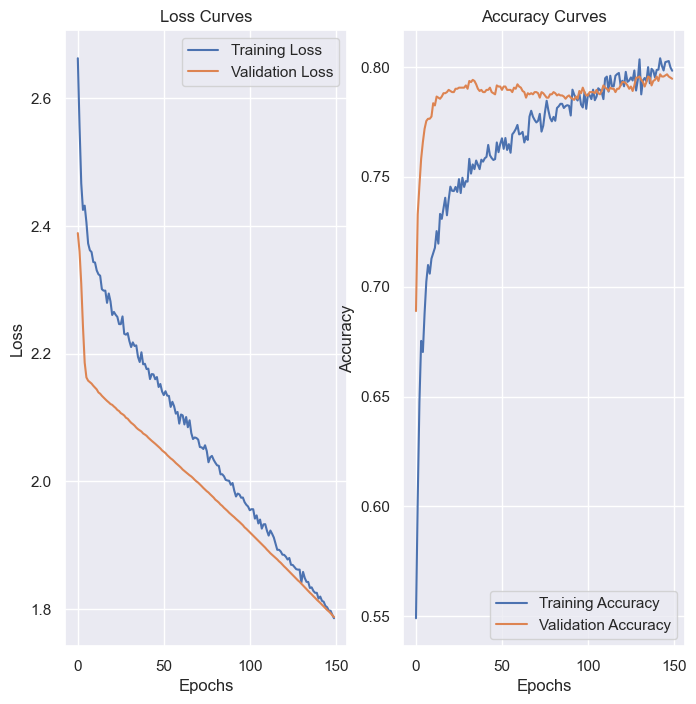

In [ ]:
# Use the function with your model's history
plot_loss_curves(model_4r_history)

In [ ]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_4r.predict(rX_test_embeddings)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m4r_time_per_instance = (end_time - start_time) / len(rX_test_embeddings)

# Calculate accuracy, precision, recall, and f1 score
m4r_accuracy = accuracy_score(ry_test, ry_pred)
m4r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m4r_recall = recall_score(ry_test, ry_pred, average='weighted')
m4r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m4r_accuracy:.2%}", f"{m4r_precision:.3f}", f"{m4r_recall:.3f}", f"{m4r_f1:.3f}", f"{m4r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Model Performance          Results
         accuracy           79.13%
        precision            0.793
           recall            0.791
         f1_score            0.791
    time/instance 0.000839 seconds


In [ ]:
store_results('Model_4r', m4r_accuracy, m4r_precision, m4r_recall, m4r_f1, m4r_time_per_instance)

# View the consolidated results
print(results_df)

## Modelling not use

### DistilBERT

In [26]:
# from transformers import DistilBertTokenizer, TFDistilBertModel

In [ ]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [28]:
#def get_distilbert_embeddings(texts):
#    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)
#    outputs = distilbert_model(encoded_inputs)
#    # Take the mean of the output embeddings to use as sentence embeddings
#    return tf.reduce_mean(outputs.last_hidden_state, axis=1)

In [29]:
# Convert texts to embeddings
#cX_train_embeddingsDBert = get_distilbert_embeddings(cX_train.tolist())
#cX_test_embeddingsDBert = get_distilbert_embeddings(cX_test.tolist())
#rX_train_embeddingsDBert = get_distilbert_embeddings(rX_train.tolist())
#rX_test_embeddingsDBert = get_distilbert_embeddings(rX_test.tolist())

: 

In [ ]:
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsDBert.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerDB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerDB, loss='binary_crossentropy', metrics=['accuracy'])

# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Train the model
#model_history = model.fit(
#    cX_train_embeddingsDBert, 
#    ry_train, 
#    batch_size=32, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
# plot_loss_curves(model_history)

### RoBERTa

In [ ]:
#from transformers import RobertaTokenizer, TFRobertaModel
#from tensorflow.keras.models import Model

/Users/antoinem/Library/r-miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
#def get_roberta_embeddings(texts):
#    # Tokenize the texts
#    encoded_input = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
#    # Get embeddings from RoBERTa model
#    outputs = roberta_model(encoded_input)
#    # Use the pooled output for classification tasks (similar to [CLS] in BERT)
#    return outputs.pooler_output

# Convert texts to embeddings
#cX_train_embeddingsBERT = get_roberta_embeddings(cX_train.tolist())
#cX_test_embeddingsBERT = get_roberta_embeddings(cX_test.tolist())
#rX_train_embeddingsBERT = get_roberta_embeddings(rX_train.tolist())
#rX_test_embeddingsBERT = get_roberta_embeddings(rX_test.tolist())

In [ ]:
# Define the model
#model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsBERT.shape[1],)),
    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Using an optimizer with adaptive learning rate
#optimizerB = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerB, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
#plot_loss_curves(model_history)

### GPT2

In [ ]:
#from transformers import TFAutoModel, AutoTokenizer, GPT2Tokenizer

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('gpt2')
#model_gpt = TFAutoModel.from_pretrained('gpt2')

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
#if tokenizer.pad_token is None:
#    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Resize model embeddings
#model_gpt.resize_token_embeddings(len(tokenizer))

#def get_gpt_embeddings(texts):
#    # Ensure input is a list of strings
#    if isinstance(texts, pd.Series):
#        texts = texts.tolist()
#    elif not isinstance(texts, list):
#        raise ValueError("Input must be a list of strings.")
    
    # Tokenize and align to the maximum sequence length expected by GPT-2
#    inputs = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="tf")
    
    # Extract last hidden states
#    outputs = model_gpt(**inputs)
#    embeddings = outputs.last_hidden_state[:, 0, :]  # Extracting embeddings from the first token
#    return embeddings


In [ ]:
#cX_train_embeddingsGPT = get_gpt_embeddings(cX_train.astype(str))
#cX_test_embeddingsGPT = get_gpt_embeddings(cX_test.astype(str))

In [ ]:
# Define the model
#model = tf.keras.Sequential([
#    tf.keras.layers.InputLayer(input_shape=(cX_train_embeddingsGPT.shape[1],)),
#    tf.keras.layers.Dense(1024, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(512, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#    tf.keras.layers.BatchNormalization(),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

# Using an optimizer with adaptive learning rate
#optimizerC = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
#model.compile(optimizer=optimizerC, loss='binary_crossentropy', metrics=['accuracy'])

# Generate the plot
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Callback for early stopping
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Number of epochs
#epochs = 300

# Fit the model
#model_history = model.fit(
#    cX_train_embeddings, 
#    cy_train, 
#    batch_size=64, 
#    epochs=epochs, 
#    validation_split=0.2, 
#    callbacks=[callback_es]
#)

# Model Summary
#print(model.summary())

In [ ]:
# Use the function with model's history
#plot_loss_curves(model_history)